In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time
import joblib

import category_encoders as ce
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 3
DATASET_VERSION = "06"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-linear-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-linear-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-linear-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
numeric_feats = list(input_feats)
len(input_feats)

1308

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting':'dart',
    'linear_tree':True,
    'objective': 'binary',
    'metric': 'None',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_bin': 511,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 0.95,
    'feature_fraction': 0.15,
    'lambda_l1': 10.352308845012756,
    'lambda_l2': 1.569788743184169,
    'min_data_in_leaf': 3000,
    'linear_lambda':10,
    #'path_smooth': 30.4965047619009,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': False,
    'verbosity': -1,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    scalers = list()
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
        
        scaler = StandardScaler(with_mean=True, with_std=True)
        scaler.fit(train_df[numeric_feats].values)
        train_df[numeric_feats] = scaler.transform(train_df[numeric_feats].values)
        valid_df[numeric_feats] = scaler.transform(valid_df[numeric_feats].values)
        
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            num_boost_round=4000,
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        scalers.append(scaler)
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return scalers,models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.758839	valid_0's recall_at4: 0.613103	valid_0's norm_gini: 0.904575


[100]	valid_0's amex_metric: 0.767237	valid_0's recall_at4: 0.625431	valid_0's norm_gini: 0.909042


[150]	valid_0's amex_metric: 0.770922	valid_0's recall_at4: 0.630523	valid_0's norm_gini: 0.911322


[200]	valid_0's amex_metric: 0.773628	valid_0's recall_at4: 0.634688	valid_0's norm_gini: 0.912567


[250]	valid_0's amex_metric: 0.777111	valid_0's recall_at4: 0.63978	valid_0's norm_gini: 0.914443


[300]	valid_0's amex_metric: 0.779236	valid_0's recall_at4: 0.642641	valid_0's norm_gini: 0.915832


[350]	valid_0's amex_metric: 0.781428	valid_0's recall_at4: 0.646007	valid_0's norm_gini: 0.916849


[400]	valid_0's amex_metric: 0.781988	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.917507


[450]	valid_0's amex_metric: 0.784837	valid_0's recall_at4: 0.651014	valid_0's norm_gini: 0.918659


[500]	valid_0's amex_metric: 0.787373	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.919693


[550]	valid_0's amex_metric: 0.788465	valid_0's recall_at4: 0.656147	valid_0's norm_gini: 0.920783


[600]	valid_0's amex_metric: 0.790774	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.921572


[650]	valid_0's amex_metric: 0.791356	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.921937


[700]	valid_0's amex_metric: 0.792576	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.922356


[750]	valid_0's amex_metric: 0.792566	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922673


[800]	valid_0's amex_metric: 0.793236	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.923087


[850]	valid_0's amex_metric: 0.793793	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.923359


[900]	valid_0's amex_metric: 0.794532	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.92366


[950]	valid_0's amex_metric: 0.79457	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.923989


[1000]	valid_0's amex_metric: 0.794927	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924238


[1050]	valid_0's amex_metric: 0.795484	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.924555


[1100]	valid_0's amex_metric: 0.795699	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.924774


[1150]	valid_0's amex_metric: 0.796636	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.92488


[1200]	valid_0's amex_metric: 0.796696	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.925


[1250]	valid_0's amex_metric: 0.797179	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925167


[1300]	valid_0's amex_metric: 0.797239	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.925203


[1350]	valid_0's amex_metric: 0.797377	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.92531


[1400]	valid_0's amex_metric: 0.797562	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.925428


[1450]	valid_0's amex_metric: 0.797449	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925539


[1500]	valid_0's amex_metric: 0.798025	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.925595


[1550]	valid_0's amex_metric: 0.7984	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.9258


[1600]	valid_0's amex_metric: 0.797833	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.925928


[1650]	valid_0's amex_metric: 0.798265	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.925993


[1700]	valid_0's amex_metric: 0.798465	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.926014


[1750]	valid_0's amex_metric: 0.798914	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926069


[1800]	valid_0's amex_metric: 0.798983	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926167


[1850]	valid_0's amex_metric: 0.798704	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.926198


[1900]	valid_0's amex_metric: 0.798809	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.926239


[1950]	valid_0's amex_metric: 0.799032	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926264


[2000]	valid_0's amex_metric: 0.799259	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926296


[2050]	valid_0's amex_metric: 0.799843	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.92633


[2100]	valid_0's amex_metric: 0.799285	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926391


[2150]	valid_0's amex_metric: 0.799484	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.92641


[2200]	valid_0's amex_metric: 0.799547	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.92641


[2250]	valid_0's amex_metric: 0.799375	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926403


[2300]	valid_0's amex_metric: 0.799212	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926413


[2350]	valid_0's amex_metric: 0.799481	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926447


[2400]	valid_0's amex_metric: 0.800079	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926423


[2450]	valid_0's amex_metric: 0.799994	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.926463


[2500]	valid_0's amex_metric: 0.799823	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926458


[2550]	valid_0's amex_metric: 0.79997	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926457


[2600]	valid_0's amex_metric: 0.800099	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926462


[2650]	valid_0's amex_metric: 0.80017	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.926478


[2700]	valid_0's amex_metric: 0.799562	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.926525


[2750]	valid_0's amex_metric: 0.799415	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926525


[2800]	valid_0's amex_metric: 0.799902	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.926531


[2850]	valid_0's amex_metric: 0.800345	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926533


[2900]	valid_0's amex_metric: 0.799603	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.926521


[2950]	valid_0's amex_metric: 0.800005	valid_0's recall_at4: 0.673483	valid_0's norm_gini: 0.926527


[3000]	valid_0's amex_metric: 0.799577	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.926513


[3050]	valid_0's amex_metric: 0.799734	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.92649


[3100]	valid_0's amex_metric: 0.799557	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.926473


[3150]	valid_0's amex_metric: 0.799239	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.926509


[3200]	valid_0's amex_metric: 0.79936	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.9265


[3250]	valid_0's amex_metric: 0.799514	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.92647


[3300]	valid_0's amex_metric: 0.799401	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926455


[3350]	valid_0's amex_metric: 0.799591	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926456


[3400]	valid_0's amex_metric: 0.799531	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.92642


[3450]	valid_0's amex_metric: 0.799761	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.926418


[3500]	valid_0's amex_metric: 0.799903	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926407


[3550]	valid_0's amex_metric: 0.799572	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926418


[3600]	valid_0's amex_metric: 0.799416	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926401


[3650]	valid_0's amex_metric: 0.80019	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.926392


[3700]	valid_0's amex_metric: 0.799884	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926369


[3750]	valid_0's amex_metric: 0.799867	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926335


[3800]	valid_0's amex_metric: 0.800378	valid_0's recall_at4: 0.674409	valid_0's norm_gini: 0.926347


[3850]	valid_0's amex_metric: 0.800077	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.926335


[3900]	valid_0's amex_metric: 0.799835	valid_0's recall_at4: 0.673357	valid_0's norm_gini: 0.926313


[3950]	valid_0's amex_metric: 0.799943	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.92632


[4000]	valid_0's amex_metric: 0.800229	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926301


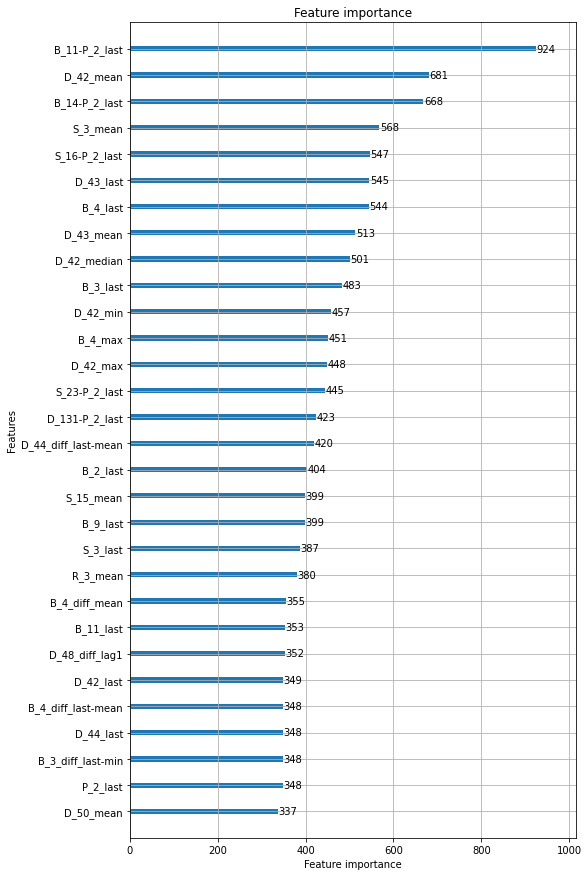

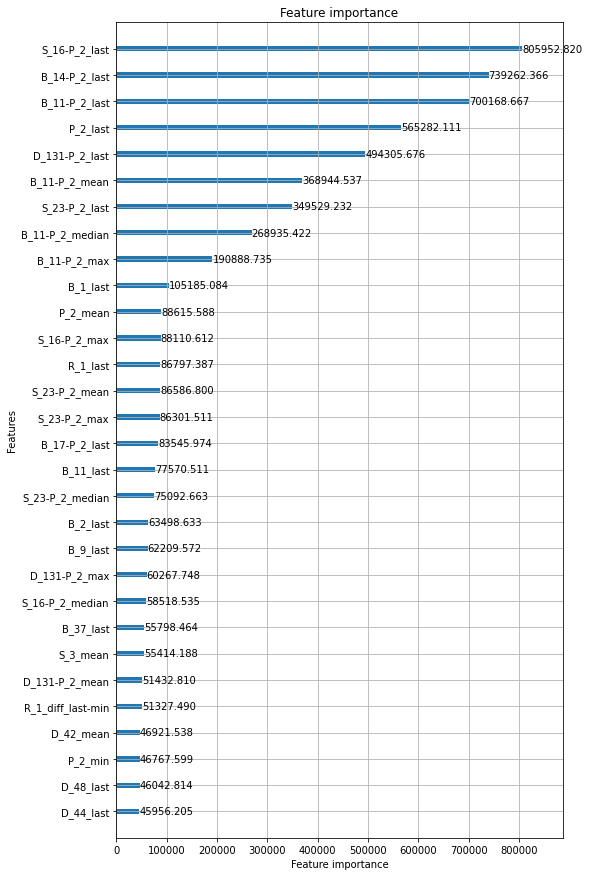

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.757061	valid_0's recall_at4: 0.610494	valid_0's norm_gini: 0.903628


[100]	valid_0's amex_metric: 0.764666	valid_0's recall_at4: 0.621224	valid_0's norm_gini: 0.908109


[150]	valid_0's amex_metric: 0.768712	valid_0's recall_at4: 0.627156	valid_0's norm_gini: 0.910267


[200]	valid_0's amex_metric: 0.769998	valid_0's recall_at4: 0.628503	valid_0's norm_gini: 0.911493


[250]	valid_0's amex_metric: 0.774624	valid_0's recall_at4: 0.635908	valid_0's norm_gini: 0.913339


[300]	valid_0's amex_metric: 0.776249	valid_0's recall_at4: 0.637634	valid_0's norm_gini: 0.914863


[350]	valid_0's amex_metric: 0.778264	valid_0's recall_at4: 0.640916	valid_0's norm_gini: 0.915612


[400]	valid_0's amex_metric: 0.778409	valid_0's recall_at4: 0.640537	valid_0's norm_gini: 0.916282


[450]	valid_0's amex_metric: 0.781217	valid_0's recall_at4: 0.645123	valid_0's norm_gini: 0.91731


[500]	valid_0's amex_metric: 0.783866	valid_0's recall_at4: 0.649289	valid_0's norm_gini: 0.918444


[550]	valid_0's amex_metric: 0.786197	valid_0's recall_at4: 0.65295	valid_0's norm_gini: 0.919444


[600]	valid_0's amex_metric: 0.789311	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.920286


[650]	valid_0's amex_metric: 0.789422	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.92076


[700]	valid_0's amex_metric: 0.789865	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.921183


[750]	valid_0's amex_metric: 0.790499	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.921527


[800]	valid_0's amex_metric: 0.791632	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.921858


[850]	valid_0's amex_metric: 0.792326	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922194


[900]	valid_0's amex_metric: 0.792284	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.922445


[950]	valid_0's amex_metric: 0.792484	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.922761


[1000]	valid_0's amex_metric: 0.793196	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.923008


[1050]	valid_0's amex_metric: 0.793536	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.923393


[1100]	valid_0's amex_metric: 0.7944	valid_0's recall_at4: 0.665194	valid_0's norm_gini: 0.923606


[1150]	valid_0's amex_metric: 0.794459	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.923767


[1200]	valid_0's amex_metric: 0.794733	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.923892


[1250]	valid_0's amex_metric: 0.794713	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.924065


[1300]	valid_0's amex_metric: 0.795624	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.924119


[1350]	valid_0's amex_metric: 0.795905	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.924218


[1400]	valid_0's amex_metric: 0.796172	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.924373


[1450]	valid_0's amex_metric: 0.795946	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.92451


[1500]	valid_0's amex_metric: 0.7961	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.924609


[1550]	valid_0's amex_metric: 0.796793	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.924731


[1600]	valid_0's amex_metric: 0.797356	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.924847


[1650]	valid_0's amex_metric: 0.79743	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.924869


[1700]	valid_0's amex_metric: 0.797681	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.924951


[1750]	valid_0's amex_metric: 0.797723	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.924993


[1800]	valid_0's amex_metric: 0.79755	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925068


[1850]	valid_0's amex_metric: 0.797391	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.925127


[1900]	valid_0's amex_metric: 0.797253	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925146


[1950]	valid_0's amex_metric: 0.797324	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925205


[2000]	valid_0's amex_metric: 0.796818	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925286


[2050]	valid_0's amex_metric: 0.797365	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925371


[2100]	valid_0's amex_metric: 0.797829	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.925541


[2150]	valid_0's amex_metric: 0.797809	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925627


[2200]	valid_0's amex_metric: 0.797836	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925639


[2250]	valid_0's amex_metric: 0.798318	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925635


[2300]	valid_0's amex_metric: 0.79867	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925624


[2350]	valid_0's amex_metric: 0.798467	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.925638


[2400]	valid_0's amex_metric: 0.797835	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.92568


[2450]	valid_0's amex_metric: 0.798398	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.925711


[2500]	valid_0's amex_metric: 0.798558	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925737


[2550]	valid_0's amex_metric: 0.799043	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925739


[2600]	valid_0's amex_metric: 0.799227	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.925812


[2650]	valid_0's amex_metric: 0.799615	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925831


[2700]	valid_0's amex_metric: 0.799899	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.925852


[2750]	valid_0's amex_metric: 0.799523	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.925858


[2800]	valid_0's amex_metric: 0.799284	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.925885


[2850]	valid_0's amex_metric: 0.799306	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.925887


[2900]	valid_0's amex_metric: 0.799376	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.925899


[2950]	valid_0's amex_metric: 0.799358	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.925906


[3000]	valid_0's amex_metric: 0.79887	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.925897


[3050]	valid_0's amex_metric: 0.800243	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.92595


[3100]	valid_0's amex_metric: 0.800516	valid_0's recall_at4: 0.67504	valid_0's norm_gini: 0.925993


[3150]	valid_0's amex_metric: 0.800379	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.926013


[3200]	valid_0's amex_metric: 0.800082	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926008


[3250]	valid_0's amex_metric: 0.800641	valid_0's recall_at4: 0.675208	valid_0's norm_gini: 0.926074


[3300]	valid_0's amex_metric: 0.800905	valid_0's recall_at4: 0.675713	valid_0's norm_gini: 0.926097


[3350]	valid_0's amex_metric: 0.801237	valid_0's recall_at4: 0.676386	valid_0's norm_gini: 0.926088


[3400]	valid_0's amex_metric: 0.80101	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926097


[3450]	valid_0's amex_metric: 0.801015	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926107


[3500]	valid_0's amex_metric: 0.800602	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.926121


[3550]	valid_0's amex_metric: 0.800041	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.926095


[3600]	valid_0's amex_metric: 0.800144	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926131


[3650]	valid_0's amex_metric: 0.800374	valid_0's recall_at4: 0.674619	valid_0's norm_gini: 0.926129


[3700]	valid_0's amex_metric: 0.800591	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.9261


[3750]	valid_0's amex_metric: 0.800209	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.926094


[3800]	valid_0's amex_metric: 0.800167	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926094


[3850]	valid_0's amex_metric: 0.800393	valid_0's recall_at4: 0.674661	valid_0's norm_gini: 0.926124


[3900]	valid_0's amex_metric: 0.800366	valid_0's recall_at4: 0.674619	valid_0's norm_gini: 0.926113


[3950]	valid_0's amex_metric: 0.80054	valid_0's recall_at4: 0.674998	valid_0's norm_gini: 0.926082


[4000]	valid_0's amex_metric: 0.800001	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.926056


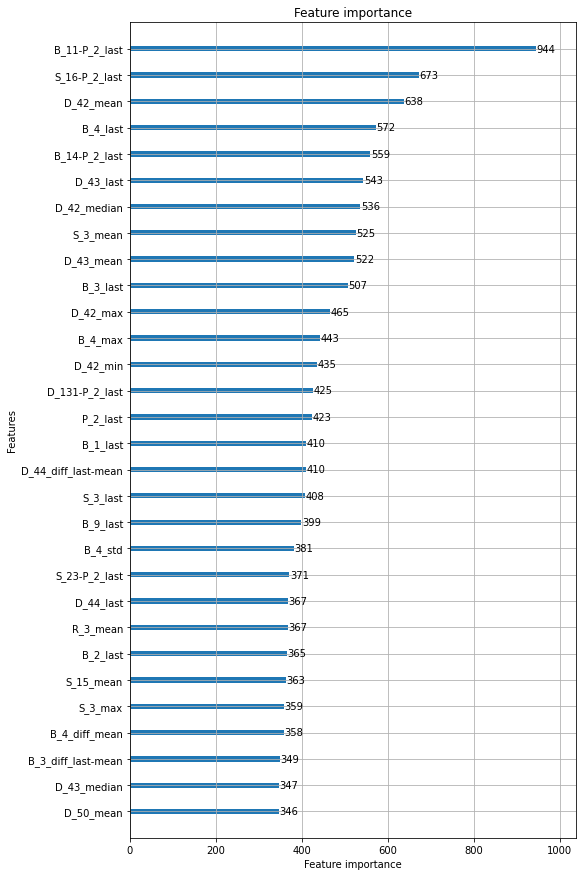

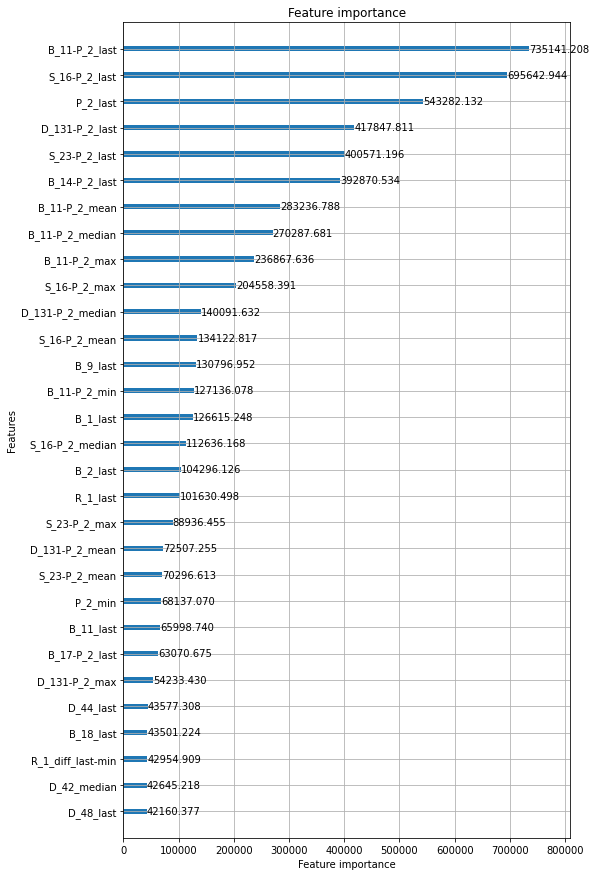

######################################## training model 3/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.75278	valid_0's recall_at4: 0.602962	valid_0's norm_gini: 0.902599


[100]	valid_0's amex_metric: 0.759648	valid_0's recall_at4: 0.612429	valid_0's norm_gini: 0.906866


[150]	valid_0's amex_metric: 0.763314	valid_0's recall_at4: 0.617521	valid_0's norm_gini: 0.909106


[200]	valid_0's amex_metric: 0.765597	valid_0's recall_at4: 0.620634	valid_0's norm_gini: 0.91056


[250]	valid_0's amex_metric: 0.769901	valid_0's recall_at4: 0.627535	valid_0's norm_gini: 0.912267


[300]	valid_0's amex_metric: 0.772842	valid_0's recall_at4: 0.632164	valid_0's norm_gini: 0.91352


[350]	valid_0's amex_metric: 0.773419	valid_0's recall_at4: 0.632374	valid_0's norm_gini: 0.914465


[400]	valid_0's amex_metric: 0.775252	valid_0's recall_at4: 0.635361	valid_0's norm_gini: 0.915143


[450]	valid_0's amex_metric: 0.776964	valid_0's recall_at4: 0.637718	valid_0's norm_gini: 0.916211


[500]	valid_0's amex_metric: 0.779774	valid_0's recall_at4: 0.642262	valid_0's norm_gini: 0.917286


[550]	valid_0's amex_metric: 0.781363	valid_0's recall_at4: 0.644492	valid_0's norm_gini: 0.918234


[600]	valid_0's amex_metric: 0.784239	valid_0's recall_at4: 0.649373	valid_0's norm_gini: 0.919105


[650]	valid_0's amex_metric: 0.784974	valid_0's recall_at4: 0.650425	valid_0's norm_gini: 0.919524


[700]	valid_0's amex_metric: 0.786226	valid_0's recall_at4: 0.652529	valid_0's norm_gini: 0.919923


[750]	valid_0's amex_metric: 0.786433	valid_0's recall_at4: 0.652613	valid_0's norm_gini: 0.920254


[800]	valid_0's amex_metric: 0.786896	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.92059


[850]	valid_0's amex_metric: 0.788152	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.920914


[900]	valid_0's amex_metric: 0.788192	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.921246


[950]	valid_0's amex_metric: 0.788591	valid_0's recall_at4: 0.655643	valid_0's norm_gini: 0.92154


[1000]	valid_0's amex_metric: 0.788832	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.921812


[1050]	valid_0's amex_metric: 0.789892	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.922164


[1100]	valid_0's amex_metric: 0.790042	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.922381


[1150]	valid_0's amex_metric: 0.790583	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.922535


[1200]	valid_0's amex_metric: 0.791608	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.922692


[1250]	valid_0's amex_metric: 0.791372	valid_0's recall_at4: 0.659892	valid_0's norm_gini: 0.922852


[1300]	valid_0's amex_metric: 0.791082	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.922903


[1350]	valid_0's amex_metric: 0.791467	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923


[1400]	valid_0's amex_metric: 0.791884	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923118


[1450]	valid_0's amex_metric: 0.792468	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.923277


[1500]	valid_0's amex_metric: 0.792242	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.923371


[1550]	valid_0's amex_metric: 0.79347	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.923554


[1600]	valid_0's amex_metric: 0.793422	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.923627


[1650]	valid_0's amex_metric: 0.793296	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.923671


[1700]	valid_0's amex_metric: 0.793759	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.923755


[1750]	valid_0's amex_metric: 0.793478	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.923823


[1800]	valid_0's amex_metric: 0.792558	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.923835


[1850]	valid_0's amex_metric: 0.79327	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.923912


[1900]	valid_0's amex_metric: 0.793548	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.923964


[1950]	valid_0's amex_metric: 0.793326	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.924025


[2000]	valid_0's amex_metric: 0.793591	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924092


[2050]	valid_0's amex_metric: 0.794032	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924133


[2100]	valid_0's amex_metric: 0.793749	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924198


[2150]	valid_0's amex_metric: 0.794077	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924223


[2200]	valid_0's amex_metric: 0.793586	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.92425


[2250]	valid_0's amex_metric: 0.793345	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.924314


[2300]	valid_0's amex_metric: 0.793751	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.924328


[2350]	valid_0's amex_metric: 0.793506	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.924342


[2400]	valid_0's amex_metric: 0.793431	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.924362


[2450]	valid_0's amex_metric: 0.793675	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924386


[2500]	valid_0's amex_metric: 0.793623	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.924365


[2550]	valid_0's amex_metric: 0.79379	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.924364


[2600]	valid_0's amex_metric: 0.794183	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.924393


[2650]	valid_0's amex_metric: 0.794219	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.92438


[2700]	valid_0's amex_metric: 0.794073	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924382


[2750]	valid_0's amex_metric: 0.794803	valid_0's recall_at4: 0.665194	valid_0's norm_gini: 0.924413


[2800]	valid_0's amex_metric: 0.794778	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.924404


[2850]	valid_0's amex_metric: 0.794323	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.924419


[2900]	valid_0's amex_metric: 0.794515	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.924426


[2950]	valid_0's amex_metric: 0.79508	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.92442


[3000]	valid_0's amex_metric: 0.794808	valid_0's recall_at4: 0.665194	valid_0's norm_gini: 0.924422


[3050]	valid_0's amex_metric: 0.794278	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924413


[3100]	valid_0's amex_metric: 0.794535	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.924423


[3150]	valid_0's amex_metric: 0.794644	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.92443


[3200]	valid_0's amex_metric: 0.794719	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.924413


[3250]	valid_0's amex_metric: 0.794599	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924425


[3300]	valid_0's amex_metric: 0.794764	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.924417


[3350]	valid_0's amex_metric: 0.794705	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924427


[3400]	valid_0's amex_metric: 0.794368	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.924384


[3450]	valid_0's amex_metric: 0.79469	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924396


[3500]	valid_0's amex_metric: 0.795108	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924349


[3550]	valid_0's amex_metric: 0.795112	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924357


[3600]	valid_0's amex_metric: 0.795523	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.924337


[3650]	valid_0's amex_metric: 0.795496	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924325


[3700]	valid_0's amex_metric: 0.795485	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924303


[3750]	valid_0's amex_metric: 0.794458	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.924269


[3800]	valid_0's amex_metric: 0.794641	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.924257


[3850]	valid_0's amex_metric: 0.793966	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.924253


[3900]	valid_0's amex_metric: 0.794411	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.924259


[3950]	valid_0's amex_metric: 0.794325	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.924255


[4000]	valid_0's amex_metric: 0.794154	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.92425


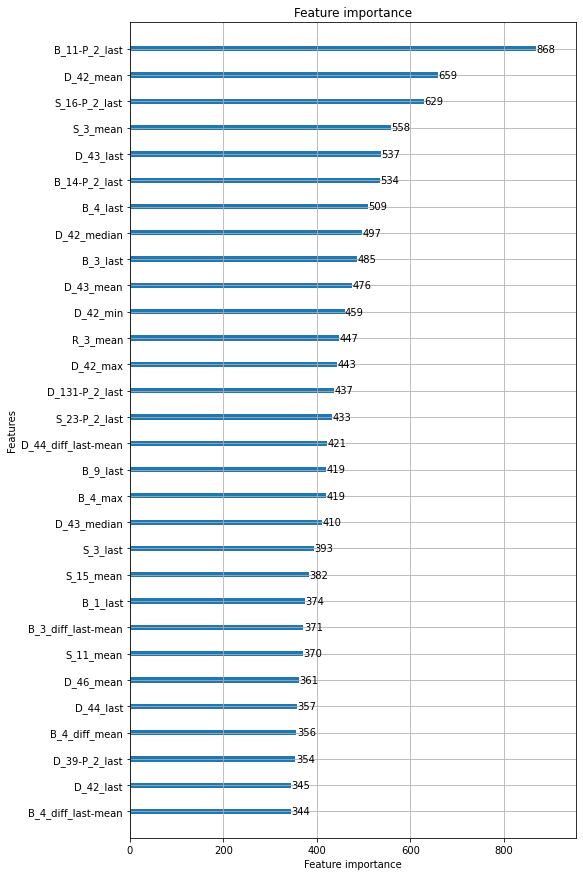

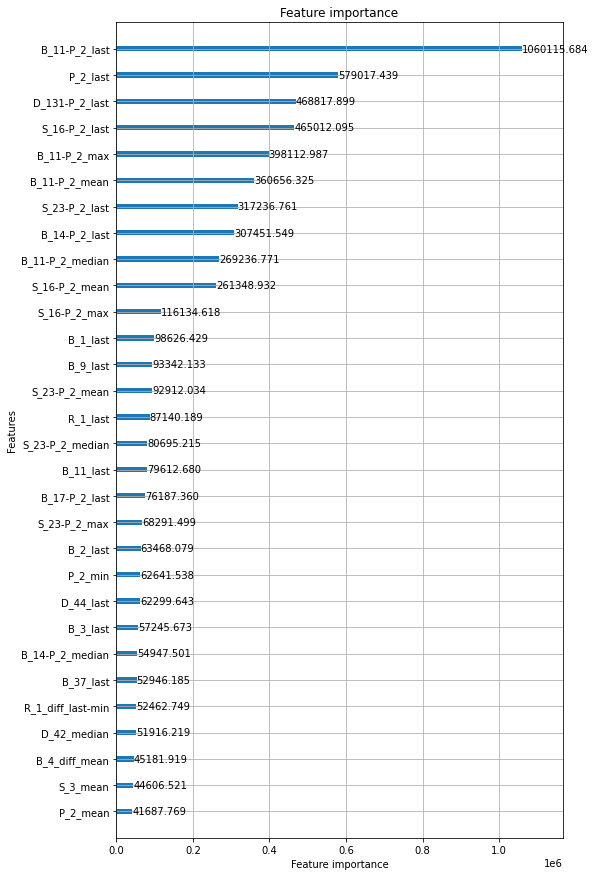

######################################## training model 4/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.752892	valid_0's recall_at4: 0.603787	valid_0's norm_gini: 0.901997


[100]	valid_0's amex_metric: 0.7605	valid_0's recall_at4: 0.614559	valid_0's norm_gini: 0.906441


[150]	valid_0's amex_metric: 0.763764	valid_0's recall_at4: 0.618599	valid_0's norm_gini: 0.908929


[200]	valid_0's amex_metric: 0.766963	valid_0's recall_at4: 0.623522	valid_0's norm_gini: 0.910405


[250]	valid_0's amex_metric: 0.770879	valid_0's recall_at4: 0.629665	valid_0's norm_gini: 0.912093


[300]	valid_0's amex_metric: 0.77305	valid_0's recall_at4: 0.632485	valid_0's norm_gini: 0.913616


[350]	valid_0's amex_metric: 0.774164	valid_0's recall_at4: 0.633873	valid_0's norm_gini: 0.914455


[400]	valid_0's amex_metric: 0.775325	valid_0's recall_at4: 0.635557	valid_0's norm_gini: 0.915094


[450]	valid_0's amex_metric: 0.77693	valid_0's recall_at4: 0.637703	valid_0's norm_gini: 0.916158


[500]	valid_0's amex_metric: 0.779319	valid_0's recall_at4: 0.641195	valid_0's norm_gini: 0.917443


[550]	valid_0's amex_metric: 0.781382	valid_0's recall_at4: 0.644309	valid_0's norm_gini: 0.918456


[600]	valid_0's amex_metric: 0.782494	valid_0's recall_at4: 0.645655	valid_0's norm_gini: 0.919333


[650]	valid_0's amex_metric: 0.783426	valid_0's recall_at4: 0.647086	valid_0's norm_gini: 0.919767


[700]	valid_0's amex_metric: 0.784691	valid_0's recall_at4: 0.649148	valid_0's norm_gini: 0.920234


[750]	valid_0's amex_metric: 0.785043	valid_0's recall_at4: 0.649569	valid_0's norm_gini: 0.920518


[800]	valid_0's amex_metric: 0.785714	valid_0's recall_at4: 0.650579	valid_0's norm_gini: 0.92085


[850]	valid_0's amex_metric: 0.785613	valid_0's recall_at4: 0.650074	valid_0's norm_gini: 0.921152


[900]	valid_0's amex_metric: 0.786476	valid_0's recall_at4: 0.651546	valid_0's norm_gini: 0.921406


[950]	valid_0's amex_metric: 0.787239	valid_0's recall_at4: 0.652725	valid_0's norm_gini: 0.921753


[1000]	valid_0's amex_metric: 0.787992	valid_0's recall_at4: 0.653945	valid_0's norm_gini: 0.92204


[1050]	valid_0's amex_metric: 0.787809	valid_0's recall_at4: 0.653272	valid_0's norm_gini: 0.922346


[1100]	valid_0's amex_metric: 0.787871	valid_0's recall_at4: 0.653145	valid_0's norm_gini: 0.922596


[1150]	valid_0's amex_metric: 0.788399	valid_0's recall_at4: 0.653987	valid_0's norm_gini: 0.922811


[1200]	valid_0's amex_metric: 0.788699	valid_0's recall_at4: 0.65445	valid_0's norm_gini: 0.922947


[1250]	valid_0's amex_metric: 0.789436	valid_0's recall_at4: 0.655712	valid_0's norm_gini: 0.923159


[1300]	valid_0's amex_metric: 0.788903	valid_0's recall_at4: 0.654618	valid_0's norm_gini: 0.923188


[1350]	valid_0's amex_metric: 0.789104	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.923296


[1400]	valid_0's amex_metric: 0.789497	valid_0's recall_at4: 0.655586	valid_0's norm_gini: 0.923407


[1450]	valid_0's amex_metric: 0.78964	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.923526


[1500]	valid_0's amex_metric: 0.789697	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.92364


[1550]	valid_0's amex_metric: 0.789865	valid_0's recall_at4: 0.655965	valid_0's norm_gini: 0.923765


[1600]	valid_0's amex_metric: 0.790245	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.923893


[1650]	valid_0's amex_metric: 0.78995	valid_0's recall_at4: 0.655923	valid_0's norm_gini: 0.923977


[1700]	valid_0's amex_metric: 0.789938	valid_0's recall_at4: 0.655838	valid_0's norm_gini: 0.924039


[1750]	valid_0's amex_metric: 0.790521	valid_0's recall_at4: 0.656932	valid_0's norm_gini: 0.92411


[1800]	valid_0's amex_metric: 0.790779	valid_0's recall_at4: 0.657353	valid_0's norm_gini: 0.924205


[1850]	valid_0's amex_metric: 0.791059	valid_0's recall_at4: 0.657816	valid_0's norm_gini: 0.924302


[1900]	valid_0's amex_metric: 0.790865	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.924292


[1950]	valid_0's amex_metric: 0.790537	valid_0's recall_at4: 0.656764	valid_0's norm_gini: 0.924309


[2000]	valid_0's amex_metric: 0.791181	valid_0's recall_at4: 0.657942	valid_0's norm_gini: 0.92442


[2050]	valid_0's amex_metric: 0.791219	valid_0's recall_at4: 0.657942	valid_0's norm_gini: 0.924496


[2100]	valid_0's amex_metric: 0.791078	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.92455


[2150]	valid_0's amex_metric: 0.79151	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.924614


[2200]	valid_0's amex_metric: 0.791854	valid_0's recall_at4: 0.659036	valid_0's norm_gini: 0.924671


[2250]	valid_0's amex_metric: 0.791754	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.924683


[2300]	valid_0's amex_metric: 0.791549	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.924692


[2350]	valid_0's amex_metric: 0.791241	valid_0's recall_at4: 0.657774	valid_0's norm_gini: 0.924707


[2400]	valid_0's amex_metric: 0.791777	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.924728


[2450]	valid_0's amex_metric: 0.791617	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.924786


[2500]	valid_0's amex_metric: 0.79182	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.924814


[2550]	valid_0's amex_metric: 0.791641	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.924834


[2600]	valid_0's amex_metric: 0.791508	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.924821


[2650]	valid_0's amex_metric: 0.792014	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.924865


[2700]	valid_0's amex_metric: 0.792022	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.924881


[2750]	valid_0's amex_metric: 0.792071	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.924895


[2800]	valid_0's amex_metric: 0.791706	valid_0's recall_at4: 0.658531	valid_0's norm_gini: 0.924882


[2850]	valid_0's amex_metric: 0.791504	valid_0's recall_at4: 0.658111	valid_0's norm_gini: 0.924898


[2900]	valid_0's amex_metric: 0.792387	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.924896


[2950]	valid_0's amex_metric: 0.792636	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.924889


[3000]	valid_0's amex_metric: 0.791927	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.924859


[3050]	valid_0's amex_metric: 0.79159	valid_0's recall_at4: 0.658321	valid_0's norm_gini: 0.924859


[3100]	valid_0's amex_metric: 0.792036	valid_0's recall_at4: 0.659205	valid_0's norm_gini: 0.924868


[3150]	valid_0's amex_metric: 0.791413	valid_0's recall_at4: 0.657942	valid_0's norm_gini: 0.924884


[3200]	valid_0's amex_metric: 0.792128	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.924882


[3250]	valid_0's amex_metric: 0.792007	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924893


[3300]	valid_0's amex_metric: 0.79164	valid_0's recall_at4: 0.658363	valid_0's norm_gini: 0.924916


[3350]	valid_0's amex_metric: 0.791918	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.924926


[3400]	valid_0's amex_metric: 0.7917	valid_0's recall_at4: 0.658489	valid_0's norm_gini: 0.924911


[3450]	valid_0's amex_metric: 0.791854	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.924882


[3500]	valid_0's amex_metric: 0.791649	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.924893


[3550]	valid_0's amex_metric: 0.792263	valid_0's recall_at4: 0.659625	valid_0's norm_gini: 0.924901


[3600]	valid_0's amex_metric: 0.792169	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.924923


[3650]	valid_0's amex_metric: 0.792341	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.924931


[3700]	valid_0's amex_metric: 0.79251	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.924932


[3750]	valid_0's amex_metric: 0.791667	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.924928


[3800]	valid_0's amex_metric: 0.792061	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.924959


[3850]	valid_0's amex_metric: 0.791953	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.924953


[3900]	valid_0's amex_metric: 0.792265	valid_0's recall_at4: 0.659583	valid_0's norm_gini: 0.924946


[3950]	valid_0's amex_metric: 0.792092	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.924938


[4000]	valid_0's amex_metric: 0.792923	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.924958


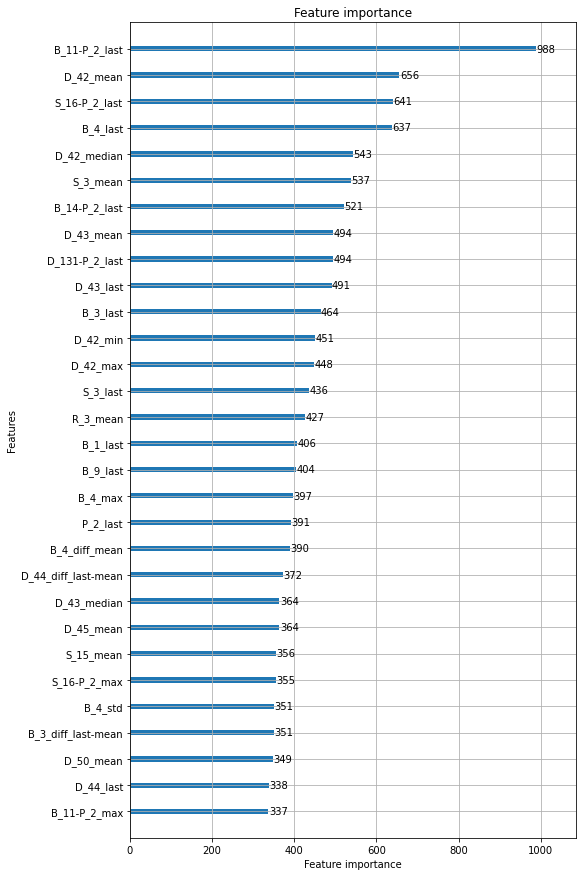

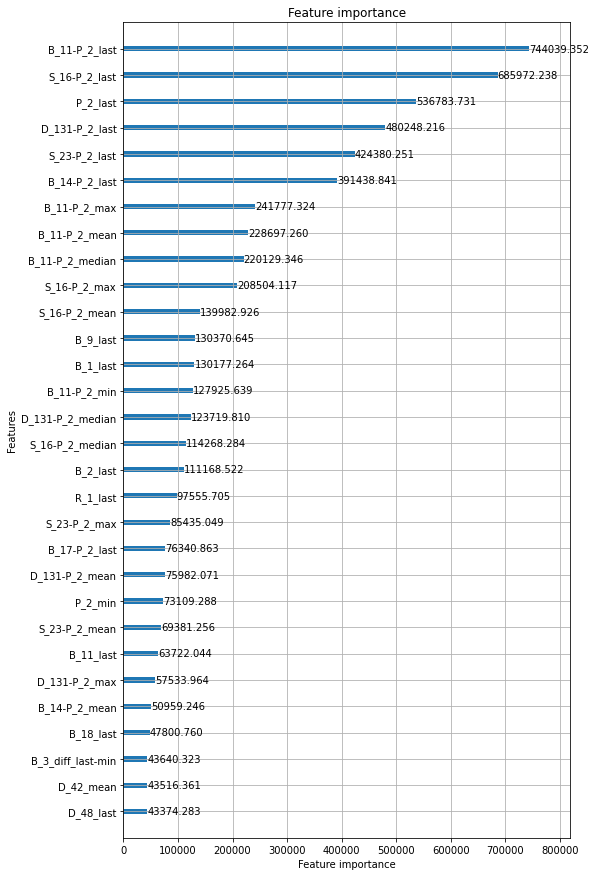

######################################## training model 5/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.762206	valid_0's recall_at4: 0.618515	valid_0's norm_gini: 0.905898


[100]	valid_0's amex_metric: 0.771276	valid_0's recall_at4: 0.63219	valid_0's norm_gini: 0.910362


[150]	valid_0's amex_metric: 0.775302	valid_0's recall_at4: 0.637829	valid_0's norm_gini: 0.912775


[200]	valid_0's amex_metric: 0.775948	valid_0's recall_at4: 0.637871	valid_0's norm_gini: 0.914025


[250]	valid_0's amex_metric: 0.780009	valid_0's recall_at4: 0.644183	valid_0's norm_gini: 0.915836


[300]	valid_0's amex_metric: 0.782754	valid_0's recall_at4: 0.648306	valid_0's norm_gini: 0.917201


[350]	valid_0's amex_metric: 0.783463	valid_0's recall_at4: 0.648938	valid_0's norm_gini: 0.917988


[400]	valid_0's amex_metric: 0.785078	valid_0's recall_at4: 0.65142	valid_0's norm_gini: 0.918736


[450]	valid_0's amex_metric: 0.786817	valid_0's recall_at4: 0.653861	valid_0's norm_gini: 0.919772


[500]	valid_0's amex_metric: 0.788178	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.920895


[550]	valid_0's amex_metric: 0.790689	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.921962


[600]	valid_0's amex_metric: 0.792556	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.922752


[650]	valid_0's amex_metric: 0.792866	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.923119


[700]	valid_0's amex_metric: 0.794045	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.923668


[750]	valid_0's amex_metric: 0.794894	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.923934


[800]	valid_0's amex_metric: 0.795066	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924279


[850]	valid_0's amex_metric: 0.796048	valid_0's recall_at4: 0.667494	valid_0's norm_gini: 0.924601


[900]	valid_0's amex_metric: 0.796381	valid_0's recall_at4: 0.667831	valid_0's norm_gini: 0.924932


[950]	valid_0's amex_metric: 0.796156	valid_0's recall_at4: 0.667158	valid_0's norm_gini: 0.925155


[1000]	valid_0's amex_metric: 0.796753	valid_0's recall_at4: 0.668041	valid_0's norm_gini: 0.925465


[1050]	valid_0's amex_metric: 0.797972	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.925798


[1100]	valid_0's amex_metric: 0.797599	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925978


[1150]	valid_0's amex_metric: 0.798225	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.926136


[1200]	valid_0's amex_metric: 0.798259	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.926205


[1250]	valid_0's amex_metric: 0.79806	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.926354


[1300]	valid_0's amex_metric: 0.79865	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.926396


[1350]	valid_0's amex_metric: 0.798981	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.92647


[1400]	valid_0's amex_metric: 0.799603	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.92662


[1450]	valid_0's amex_metric: 0.800151	valid_0's recall_at4: 0.673554	valid_0's norm_gini: 0.926748


[1500]	valid_0's amex_metric: 0.800128	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.92683


[1550]	valid_0's amex_metric: 0.799883	valid_0's recall_at4: 0.672796	valid_0's norm_gini: 0.92697


[1600]	valid_0's amex_metric: 0.800493	valid_0's recall_at4: 0.67389	valid_0's norm_gini: 0.927095


[1650]	valid_0's amex_metric: 0.800311	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.927194


[1700]	valid_0's amex_metric: 0.80084	valid_0's recall_at4: 0.674437	valid_0's norm_gini: 0.927244


[1750]	valid_0's amex_metric: 0.801666	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.927339


[1800]	valid_0's amex_metric: 0.801979	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.927416


[1850]	valid_0's amex_metric: 0.802531	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.92747


[1900]	valid_0's amex_metric: 0.802144	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927494


[1950]	valid_0's amex_metric: 0.802238	valid_0's recall_at4: 0.676962	valid_0's norm_gini: 0.927515


[2000]	valid_0's amex_metric: 0.802654	valid_0's recall_at4: 0.677719	valid_0's norm_gini: 0.927589


[2050]	valid_0's amex_metric: 0.803167	valid_0's recall_at4: 0.678645	valid_0's norm_gini: 0.927688


[2100]	valid_0's amex_metric: 0.803127	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.927777


[2150]	valid_0's amex_metric: 0.803027	valid_0's recall_at4: 0.678266	valid_0's norm_gini: 0.927789


[2200]	valid_0's amex_metric: 0.803623	valid_0's recall_at4: 0.679402	valid_0's norm_gini: 0.927844


[2250]	valid_0's amex_metric: 0.803279	valid_0's recall_at4: 0.678687	valid_0's norm_gini: 0.927871


[2300]	valid_0's amex_metric: 0.803711	valid_0's recall_at4: 0.679571	valid_0's norm_gini: 0.927851


[2350]	valid_0's amex_metric: 0.803995	valid_0's recall_at4: 0.680118	valid_0's norm_gini: 0.927872


[2400]	valid_0's amex_metric: 0.804179	valid_0's recall_at4: 0.680454	valid_0's norm_gini: 0.927903


[2450]	valid_0's amex_metric: 0.803814	valid_0's recall_at4: 0.679739	valid_0's norm_gini: 0.927889


[2500]	valid_0's amex_metric: 0.804593	valid_0's recall_at4: 0.681254	valid_0's norm_gini: 0.927933


[2550]	valid_0's amex_metric: 0.804322	valid_0's recall_at4: 0.680665	valid_0's norm_gini: 0.92798


[2600]	valid_0's amex_metric: 0.804067	valid_0's recall_at4: 0.680118	valid_0's norm_gini: 0.928016


[2650]	valid_0's amex_metric: 0.804617	valid_0's recall_at4: 0.681212	valid_0's norm_gini: 0.928022


[2700]	valid_0's amex_metric: 0.804647	valid_0's recall_at4: 0.681254	valid_0's norm_gini: 0.928039


[2750]	valid_0's amex_metric: 0.804955	valid_0's recall_at4: 0.681843	valid_0's norm_gini: 0.928067


[2800]	valid_0's amex_metric: 0.804794	valid_0's recall_at4: 0.681548	valid_0's norm_gini: 0.928039


[2850]	valid_0's amex_metric: 0.805174	valid_0's recall_at4: 0.682264	valid_0's norm_gini: 0.928085


[2900]	valid_0's amex_metric: 0.805183	valid_0's recall_at4: 0.682264	valid_0's norm_gini: 0.928102


[2950]	valid_0's amex_metric: 0.805318	valid_0's recall_at4: 0.682558	valid_0's norm_gini: 0.928077


[3000]	valid_0's amex_metric: 0.804617	valid_0's recall_at4: 0.681128	valid_0's norm_gini: 0.928106


[3050]	valid_0's amex_metric: 0.80537	valid_0's recall_at4: 0.6826	valid_0's norm_gini: 0.92814


[3100]	valid_0's amex_metric: 0.805578	valid_0's recall_at4: 0.683021	valid_0's norm_gini: 0.928135


[3150]	valid_0's amex_metric: 0.805249	valid_0's recall_at4: 0.682306	valid_0's norm_gini: 0.928192


[3200]	valid_0's amex_metric: 0.804959	valid_0's recall_at4: 0.681717	valid_0's norm_gini: 0.928201


[3250]	valid_0's amex_metric: 0.804675	valid_0's recall_at4: 0.681128	valid_0's norm_gini: 0.928223


[3300]	valid_0's amex_metric: 0.804334	valid_0's recall_at4: 0.680454	valid_0's norm_gini: 0.928214


[3350]	valid_0's amex_metric: 0.80467	valid_0's recall_at4: 0.681128	valid_0's norm_gini: 0.928212


[3400]	valid_0's amex_metric: 0.80421	valid_0's recall_at4: 0.680202	valid_0's norm_gini: 0.928218


[3450]	valid_0's amex_metric: 0.804026	valid_0's recall_at4: 0.679823	valid_0's norm_gini: 0.928229


[3500]	valid_0's amex_metric: 0.804266	valid_0's recall_at4: 0.680328	valid_0's norm_gini: 0.928204


[3550]	valid_0's amex_metric: 0.804521	valid_0's recall_at4: 0.680833	valid_0's norm_gini: 0.928209


[3600]	valid_0's amex_metric: 0.804309	valid_0's recall_at4: 0.680412	valid_0's norm_gini: 0.928205


[3650]	valid_0's amex_metric: 0.804333	valid_0's recall_at4: 0.680454	valid_0's norm_gini: 0.928211


[3700]	valid_0's amex_metric: 0.804127	valid_0's recall_at4: 0.680076	valid_0's norm_gini: 0.928177


[3750]	valid_0's amex_metric: 0.804005	valid_0's recall_at4: 0.679823	valid_0's norm_gini: 0.928187


[3800]	valid_0's amex_metric: 0.803629	valid_0's recall_at4: 0.679066	valid_0's norm_gini: 0.928192


[3850]	valid_0's amex_metric: 0.804108	valid_0's recall_at4: 0.680034	valid_0's norm_gini: 0.928182


[3900]	valid_0's amex_metric: 0.804159	valid_0's recall_at4: 0.68016	valid_0's norm_gini: 0.928158


[3950]	valid_0's amex_metric: 0.804106	valid_0's recall_at4: 0.680076	valid_0's norm_gini: 0.928136


[4000]	valid_0's amex_metric: 0.80371	valid_0's recall_at4: 0.679276	valid_0's norm_gini: 0.928144


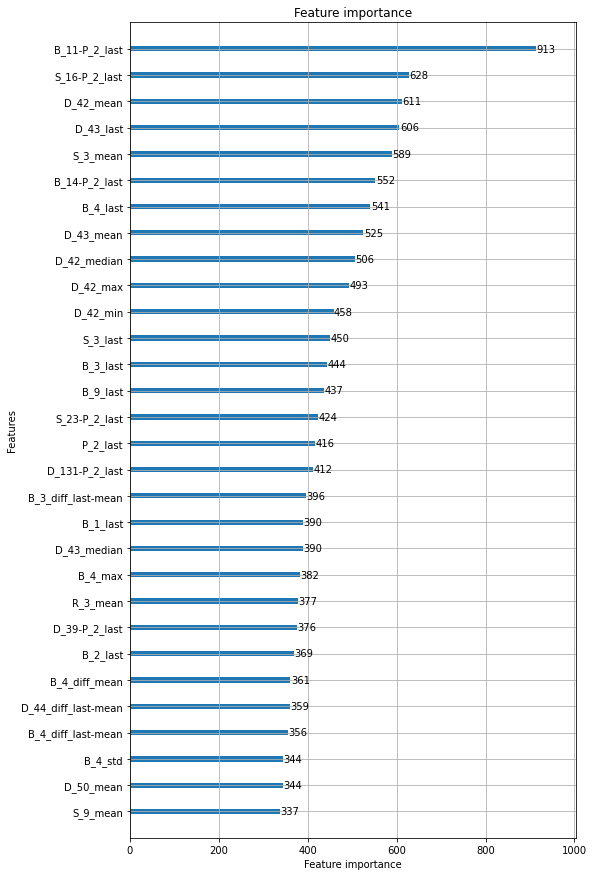

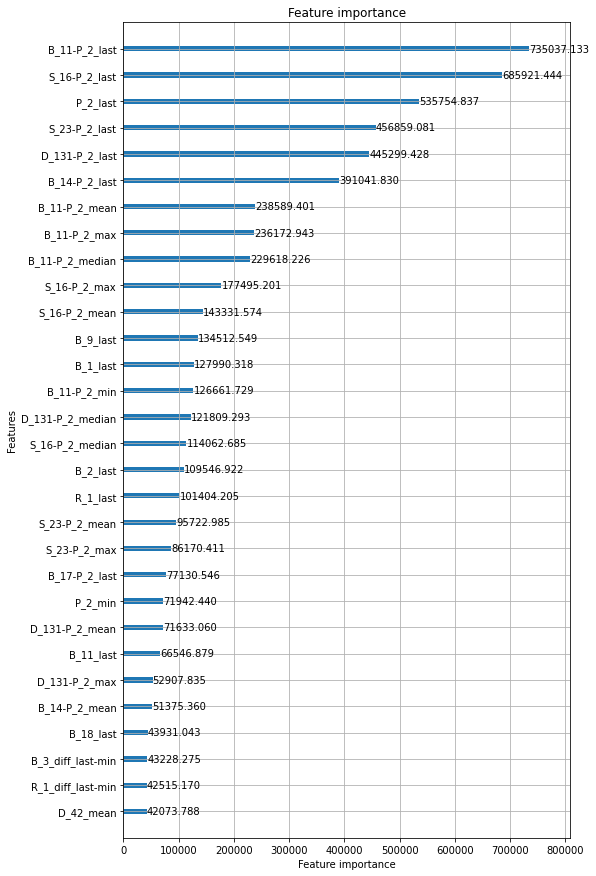

Training time: 98.77187960147857 min.


OOF recall_at4: 0.6705406133234592


OOF normalized_gini: 0.9258098241803581


OOF competition metric: 0.7981752187519087


############################### repeated cross-validation step: 2/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.758807	valid_0's recall_at4: 0.613271	valid_0's norm_gini: 0.904342


[100]	valid_0's amex_metric: 0.76823	valid_0's recall_at4: 0.627619	valid_0's norm_gini: 0.90884


[150]	valid_0's amex_metric: 0.772473	valid_0's recall_at4: 0.633805	valid_0's norm_gini: 0.911142


[200]	valid_0's amex_metric: 0.774163	valid_0's recall_at4: 0.635782	valid_0's norm_gini: 0.912543


[250]	valid_0's amex_metric: 0.777954	valid_0's recall_at4: 0.641547	valid_0's norm_gini: 0.914362


[300]	valid_0's amex_metric: 0.780739	valid_0's recall_at4: 0.64567	valid_0's norm_gini: 0.915808


[350]	valid_0's amex_metric: 0.781463	valid_0's recall_at4: 0.646301	valid_0's norm_gini: 0.916624


[400]	valid_0's amex_metric: 0.782717	valid_0's recall_at4: 0.648111	valid_0's norm_gini: 0.917323


[450]	valid_0's amex_metric: 0.784505	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.918332


[500]	valid_0's amex_metric: 0.786218	valid_0's recall_at4: 0.652823	valid_0's norm_gini: 0.919612


[550]	valid_0's amex_metric: 0.788823	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.920657


[600]	valid_0's amex_metric: 0.79063	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.921452


[650]	valid_0's amex_metric: 0.790669	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.921909


[700]	valid_0's amex_metric: 0.791441	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.9224


[750]	valid_0's amex_metric: 0.792101	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.922711


[800]	valid_0's amex_metric: 0.793246	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.923023


[850]	valid_0's amex_metric: 0.793865	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.923336


[900]	valid_0's amex_metric: 0.794126	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.923647


[950]	valid_0's amex_metric: 0.794767	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.924004


[1000]	valid_0's amex_metric: 0.795346	valid_0's recall_at4: 0.666414	valid_0's norm_gini: 0.924277


[1050]	valid_0's amex_metric: 0.796126	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.924617


[1100]	valid_0's amex_metric: 0.795636	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.924816


[1150]	valid_0's amex_metric: 0.796403	valid_0's recall_at4: 0.667845	valid_0's norm_gini: 0.924961


[1200]	valid_0's amex_metric: 0.79777	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.925087


[1250]	valid_0's amex_metric: 0.797372	valid_0's recall_at4: 0.66957	valid_0's norm_gini: 0.925174


[1300]	valid_0's amex_metric: 0.797234	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.925192


[1350]	valid_0's amex_metric: 0.797659	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925328


[1400]	valid_0's amex_metric: 0.797691	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.925475


[1450]	valid_0's amex_metric: 0.798688	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.925575


[1500]	valid_0's amex_metric: 0.798582	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925701


[1550]	valid_0's amex_metric: 0.798687	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.925827


[1600]	valid_0's amex_metric: 0.799783	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.925915


[1650]	valid_0's amex_metric: 0.799898	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.925975


[1700]	valid_0's amex_metric: 0.800145	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.92605


[1750]	valid_0's amex_metric: 0.800616	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.92615


[1800]	valid_0's amex_metric: 0.801062	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.9262


[1850]	valid_0's amex_metric: 0.801121	valid_0's recall_at4: 0.676008	valid_0's norm_gini: 0.926235


[1900]	valid_0's amex_metric: 0.800986	valid_0's recall_at4: 0.675713	valid_0's norm_gini: 0.926258


[1950]	valid_0's amex_metric: 0.801535	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.926305


[2000]	valid_0's amex_metric: 0.801732	valid_0's recall_at4: 0.677102	valid_0's norm_gini: 0.926363


[2050]	valid_0's amex_metric: 0.801728	valid_0's recall_at4: 0.677018	valid_0's norm_gini: 0.926439


[2100]	valid_0's amex_metric: 0.801766	valid_0's recall_at4: 0.67706	valid_0's norm_gini: 0.926472


[2150]	valid_0's amex_metric: 0.801505	valid_0's recall_at4: 0.676471	valid_0's norm_gini: 0.92654


[2200]	valid_0's amex_metric: 0.801387	valid_0's recall_at4: 0.676176	valid_0's norm_gini: 0.926599


[2250]	valid_0's amex_metric: 0.800834	valid_0's recall_at4: 0.67504	valid_0's norm_gini: 0.926629


[2300]	valid_0's amex_metric: 0.800936	valid_0's recall_at4: 0.675208	valid_0's norm_gini: 0.926664


[2350]	valid_0's amex_metric: 0.800282	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.926659


[2400]	valid_0's amex_metric: 0.801313	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926702


[2450]	valid_0's amex_metric: 0.801248	valid_0's recall_at4: 0.675797	valid_0's norm_gini: 0.926698


[2500]	valid_0's amex_metric: 0.801567	valid_0's recall_at4: 0.676428	valid_0's norm_gini: 0.926706


[2550]	valid_0's amex_metric: 0.801581	valid_0's recall_at4: 0.676386	valid_0's norm_gini: 0.926776


[2600]	valid_0's amex_metric: 0.801302	valid_0's recall_at4: 0.675797	valid_0's norm_gini: 0.926806


[2650]	valid_0's amex_metric: 0.801037	valid_0's recall_at4: 0.67525	valid_0's norm_gini: 0.926824


[2700]	valid_0's amex_metric: 0.800907	valid_0's recall_at4: 0.674956	valid_0's norm_gini: 0.926859


[2750]	valid_0's amex_metric: 0.800989	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.926897


[2800]	valid_0's amex_metric: 0.800752	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.926928


[2850]	valid_0's amex_metric: 0.801148	valid_0's recall_at4: 0.675377	valid_0's norm_gini: 0.926919


[2900]	valid_0's amex_metric: 0.801772	valid_0's recall_at4: 0.676639	valid_0's norm_gini: 0.926905


[2950]	valid_0's amex_metric: 0.801408	valid_0's recall_at4: 0.675966	valid_0's norm_gini: 0.92685


[3000]	valid_0's amex_metric: 0.801803	valid_0's recall_at4: 0.676723	valid_0's norm_gini: 0.926883


[3050]	valid_0's amex_metric: 0.801976	valid_0's recall_at4: 0.67706	valid_0's norm_gini: 0.926893


[3100]	valid_0's amex_metric: 0.802159	valid_0's recall_at4: 0.677438	valid_0's norm_gini: 0.926879


[3150]	valid_0's amex_metric: 0.801833	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.9269


[3200]	valid_0's amex_metric: 0.801598	valid_0's recall_at4: 0.676302	valid_0's norm_gini: 0.926894


[3250]	valid_0's amex_metric: 0.801777	valid_0's recall_at4: 0.676639	valid_0's norm_gini: 0.926916


[3300]	valid_0's amex_metric: 0.802061	valid_0's recall_at4: 0.677228	valid_0's norm_gini: 0.926894


[3350]	valid_0's amex_metric: 0.802169	valid_0's recall_at4: 0.677438	valid_0's norm_gini: 0.926899


[3400]	valid_0's amex_metric: 0.802012	valid_0's recall_at4: 0.677144	valid_0's norm_gini: 0.92688


[3450]	valid_0's amex_metric: 0.80187	valid_0's recall_at4: 0.676849	valid_0's norm_gini: 0.926891


[3500]	valid_0's amex_metric: 0.801756	valid_0's recall_at4: 0.676639	valid_0's norm_gini: 0.926874


[3550]	valid_0's amex_metric: 0.80169	valid_0's recall_at4: 0.676513	valid_0's norm_gini: 0.926868


[3600]	valid_0's amex_metric: 0.801398	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926872


[3650]	valid_0's amex_metric: 0.801801	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.926837


[3700]	valid_0's amex_metric: 0.801387	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926851


[3750]	valid_0's amex_metric: 0.8016	valid_0's recall_at4: 0.676386	valid_0's norm_gini: 0.926814


[3800]	valid_0's amex_metric: 0.80148	valid_0's recall_at4: 0.676134	valid_0's norm_gini: 0.926827


[3850]	valid_0's amex_metric: 0.801313	valid_0's recall_at4: 0.675839	valid_0's norm_gini: 0.926786


[3900]	valid_0's amex_metric: 0.80123	valid_0's recall_at4: 0.675629	valid_0's norm_gini: 0.92683


[3950]	valid_0's amex_metric: 0.801501	valid_0's recall_at4: 0.676176	valid_0's norm_gini: 0.926827


[4000]	valid_0's amex_metric: 0.801363	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.926803


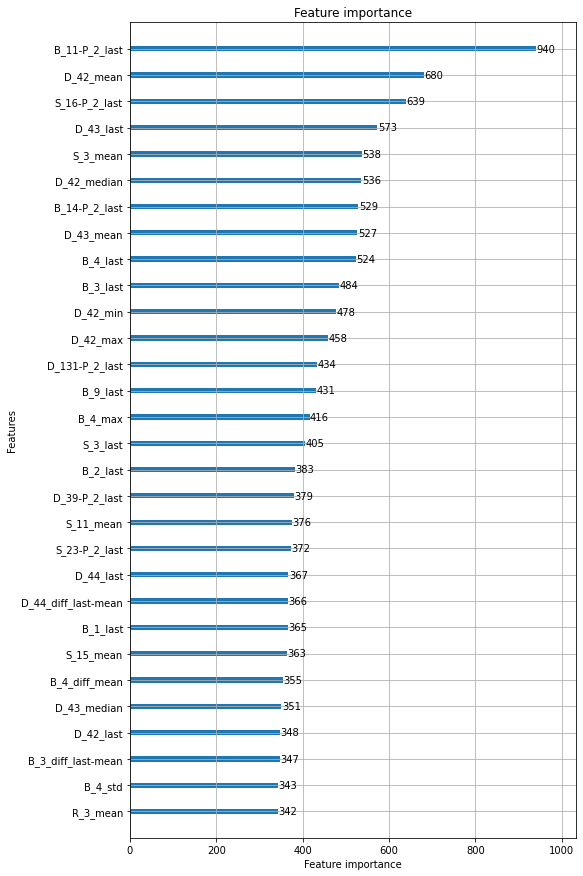

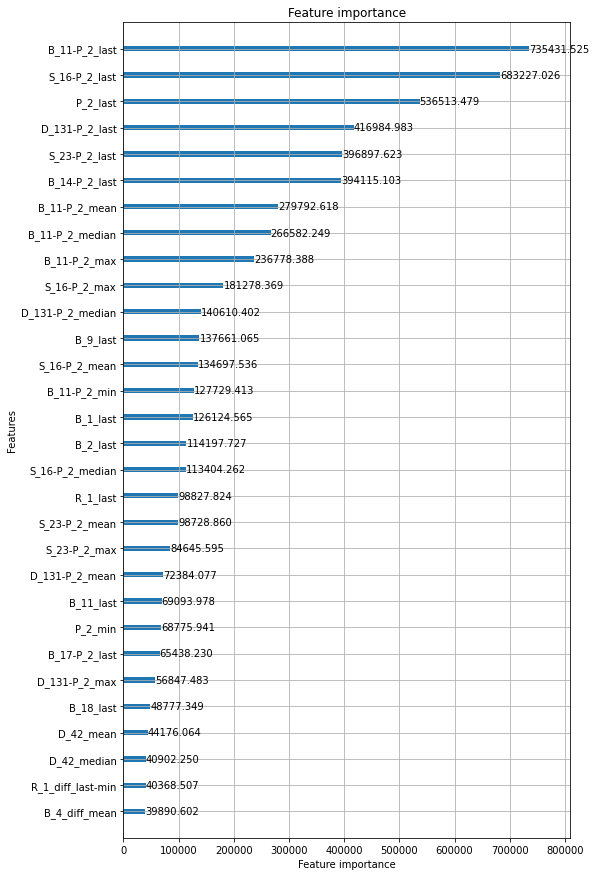

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.755541	valid_0's recall_at4: 0.607843	valid_0's norm_gini: 0.903239


[100]	valid_0's amex_metric: 0.761401	valid_0's recall_at4: 0.61508	valid_0's norm_gini: 0.907721


[150]	valid_0's amex_metric: 0.766955	valid_0's recall_at4: 0.623832	valid_0's norm_gini: 0.910078


[200]	valid_0's amex_metric: 0.768844	valid_0's recall_at4: 0.626273	valid_0's norm_gini: 0.911416


[250]	valid_0's amex_metric: 0.773142	valid_0's recall_at4: 0.633005	valid_0's norm_gini: 0.913278


[300]	valid_0's amex_metric: 0.774533	valid_0's recall_at4: 0.634394	valid_0's norm_gini: 0.914673


[350]	valid_0's amex_metric: 0.775547	valid_0's recall_at4: 0.635614	valid_0's norm_gini: 0.91548


[400]	valid_0's amex_metric: 0.77758	valid_0's recall_at4: 0.63898	valid_0's norm_gini: 0.91618


[450]	valid_0's amex_metric: 0.779256	valid_0's recall_at4: 0.64121	valid_0's norm_gini: 0.917301


[500]	valid_0's amex_metric: 0.781365	valid_0's recall_at4: 0.644324	valid_0's norm_gini: 0.918405


[550]	valid_0's amex_metric: 0.783371	valid_0's recall_at4: 0.647395	valid_0's norm_gini: 0.919346


[600]	valid_0's amex_metric: 0.784578	valid_0's recall_at4: 0.648994	valid_0's norm_gini: 0.920162


[650]	valid_0's amex_metric: 0.785153	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.920469


[700]	valid_0's amex_metric: 0.786887	valid_0's recall_at4: 0.652781	valid_0's norm_gini: 0.920992


[750]	valid_0's amex_metric: 0.786826	valid_0's recall_at4: 0.652318	valid_0's norm_gini: 0.921334


[800]	valid_0's amex_metric: 0.788036	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.92165


[850]	valid_0's amex_metric: 0.788413	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.921942


[900]	valid_0's amex_metric: 0.788689	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.922198


[950]	valid_0's amex_metric: 0.78859	valid_0's recall_at4: 0.654633	valid_0's norm_gini: 0.922548


[1000]	valid_0's amex_metric: 0.789756	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.922776


[1050]	valid_0's amex_metric: 0.791129	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.923122


[1100]	valid_0's amex_metric: 0.790791	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.923331


[1150]	valid_0's amex_metric: 0.791945	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.923535


[1200]	valid_0's amex_metric: 0.792152	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.923696


[1250]	valid_0's amex_metric: 0.792505	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.923856


[1300]	valid_0's amex_metric: 0.792574	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.923909


[1350]	valid_0's amex_metric: 0.792839	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.924019


[1400]	valid_0's amex_metric: 0.792937	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.924131


[1450]	valid_0's amex_metric: 0.793103	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.924251


[1500]	valid_0's amex_metric: 0.792998	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.924336


[1550]	valid_0's amex_metric: 0.793361	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.924474


[1600]	valid_0's amex_metric: 0.794165	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.92461


[1650]	valid_0's amex_metric: 0.794376	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.924652


[1700]	valid_0's amex_metric: 0.794101	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.924733


[1750]	valid_0's amex_metric: 0.794647	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.924815


[1800]	valid_0's amex_metric: 0.795147	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.924889


[1850]	valid_0's amex_metric: 0.794964	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924945


[1900]	valid_0's amex_metric: 0.794993	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.925003


[1950]	valid_0's amex_metric: 0.794887	valid_0's recall_at4: 0.664731	valid_0's norm_gini: 0.925043


[2000]	valid_0's amex_metric: 0.795661	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.925118


[2050]	valid_0's amex_metric: 0.795621	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.925207


[2100]	valid_0's amex_metric: 0.79553	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.925278


[2150]	valid_0's amex_metric: 0.796265	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.925316


[2200]	valid_0's amex_metric: 0.795997	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.925327


[2250]	valid_0's amex_metric: 0.79538	valid_0's recall_at4: 0.665446	valid_0's norm_gini: 0.925313


[2300]	valid_0's amex_metric: 0.795592	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.925359


[2350]	valid_0's amex_metric: 0.796017	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.925367


[2400]	valid_0's amex_metric: 0.79537	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.925378


[2450]	valid_0's amex_metric: 0.79546	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.925389


[2500]	valid_0's amex_metric: 0.795406	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.925407


[2550]	valid_0's amex_metric: 0.79547	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.925451


[2600]	valid_0's amex_metric: 0.795782	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.925487


[2650]	valid_0's amex_metric: 0.795756	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.925519


[2700]	valid_0's amex_metric: 0.795398	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.925559


[2750]	valid_0's amex_metric: 0.795806	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.925576


[2800]	valid_0's amex_metric: 0.796606	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.925578


[2850]	valid_0's amex_metric: 0.796386	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.925599


[2900]	valid_0's amex_metric: 0.796591	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.925633


[2950]	valid_0's amex_metric: 0.7967	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.92564


[3000]	valid_0's amex_metric: 0.796909	valid_0's recall_at4: 0.668181	valid_0's norm_gini: 0.925638


[3050]	valid_0's amex_metric: 0.796888	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925638


[3100]	valid_0's amex_metric: 0.79662	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.925689


[3150]	valid_0's amex_metric: 0.7965	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.92566


[3200]	valid_0's amex_metric: 0.79688	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.925706


[3250]	valid_0's amex_metric: 0.796545	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.925708


[3300]	valid_0's amex_metric: 0.796717	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.925716


[3350]	valid_0's amex_metric: 0.796547	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.925712


[3400]	valid_0's amex_metric: 0.796513	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.925686


[3450]	valid_0's amex_metric: 0.796563	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.92566


[3500]	valid_0's amex_metric: 0.796223	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.925654


[3550]	valid_0's amex_metric: 0.796322	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.9256


[3600]	valid_0's amex_metric: 0.795587	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.925601


[3650]	valid_0's amex_metric: 0.795594	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.925616


[3700]	valid_0's amex_metric: 0.796132	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.925639


[3750]	valid_0's amex_metric: 0.795967	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.925646


[3800]	valid_0's amex_metric: 0.795908	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.925654


[3850]	valid_0's amex_metric: 0.795611	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.925649


[3900]	valid_0's amex_metric: 0.795904	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.925646


[3950]	valid_0's amex_metric: 0.796235	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.925636


[4000]	valid_0's amex_metric: 0.796673	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.925669


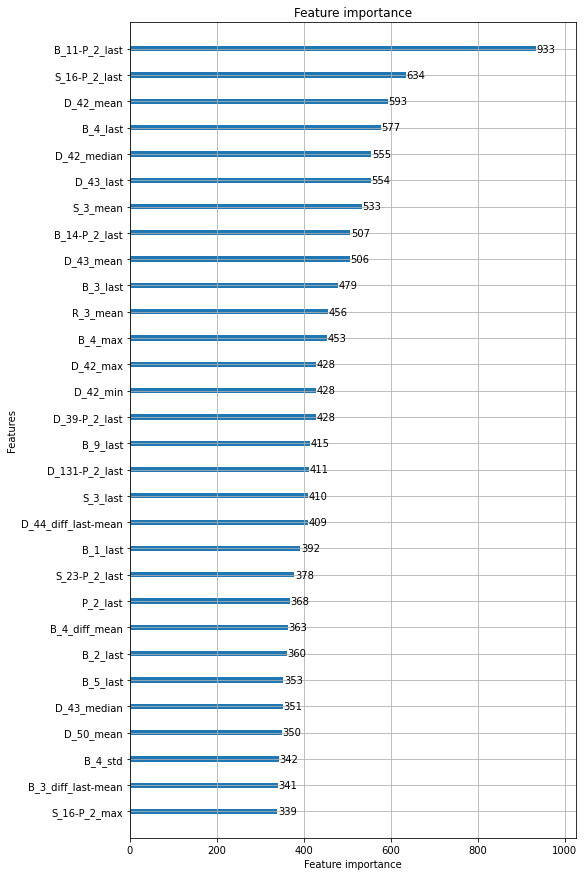

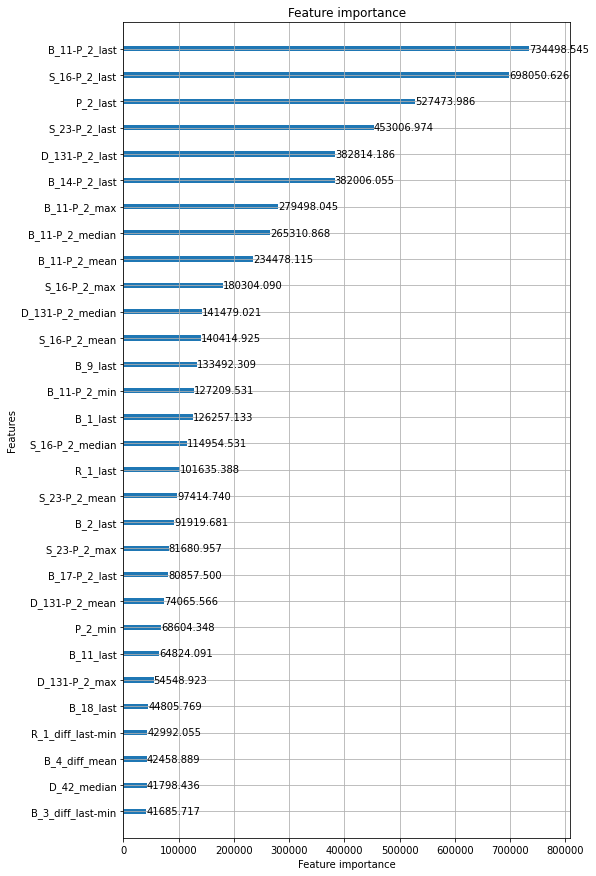

######################################## training model 3/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.753146	valid_0's recall_at4: 0.604351	valid_0's norm_gini: 0.901942


[100]	valid_0's amex_metric: 0.760546	valid_0's recall_at4: 0.615038	valid_0's norm_gini: 0.906054


[150]	valid_0's amex_metric: 0.763586	valid_0's recall_at4: 0.618489	valid_0's norm_gini: 0.908684


[200]	valid_0's amex_metric: 0.76634	valid_0's recall_at4: 0.622486	valid_0's norm_gini: 0.910194


[250]	valid_0's amex_metric: 0.769188	valid_0's recall_at4: 0.626357	valid_0's norm_gini: 0.912019


[300]	valid_0's amex_metric: 0.772574	valid_0's recall_at4: 0.631617	valid_0's norm_gini: 0.913532


[350]	valid_0's amex_metric: 0.773763	valid_0's recall_at4: 0.633131	valid_0's norm_gini: 0.914394


[400]	valid_0's amex_metric: 0.774456	valid_0's recall_at4: 0.633763	valid_0's norm_gini: 0.91515


[450]	valid_0's amex_metric: 0.776347	valid_0's recall_at4: 0.636371	valid_0's norm_gini: 0.916324


[500]	valid_0's amex_metric: 0.778011	valid_0's recall_at4: 0.638517	valid_0's norm_gini: 0.917504


[550]	valid_0's amex_metric: 0.780751	valid_0's recall_at4: 0.642977	valid_0's norm_gini: 0.918524


[600]	valid_0's amex_metric: 0.782759	valid_0's recall_at4: 0.646091	valid_0's norm_gini: 0.919427


[650]	valid_0's amex_metric: 0.783476	valid_0's recall_at4: 0.647059	valid_0's norm_gini: 0.919892


[700]	valid_0's amex_metric: 0.784893	valid_0's recall_at4: 0.649415	valid_0's norm_gini: 0.92037


[750]	valid_0's amex_metric: 0.785074	valid_0's recall_at4: 0.649457	valid_0's norm_gini: 0.920691


[800]	valid_0's amex_metric: 0.785471	valid_0's recall_at4: 0.64992	valid_0's norm_gini: 0.921021


[850]	valid_0's amex_metric: 0.786398	valid_0's recall_at4: 0.651477	valid_0's norm_gini: 0.921319


[900]	valid_0's amex_metric: 0.786873	valid_0's recall_at4: 0.652066	valid_0's norm_gini: 0.92168


[950]	valid_0's amex_metric: 0.78769	valid_0's recall_at4: 0.653328	valid_0's norm_gini: 0.922052


[1000]	valid_0's amex_metric: 0.788615	valid_0's recall_at4: 0.654927	valid_0's norm_gini: 0.922303


[1050]	valid_0's amex_metric: 0.788976	valid_0's recall_at4: 0.655306	valid_0's norm_gini: 0.922646


[1100]	valid_0's amex_metric: 0.790047	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.922852


[1150]	valid_0's amex_metric: 0.790632	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.923055


[1200]	valid_0's amex_metric: 0.791276	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.923164


[1250]	valid_0's amex_metric: 0.791807	valid_0's recall_at4: 0.660271	valid_0's norm_gini: 0.923342


[1300]	valid_0's amex_metric: 0.791827	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.92334


[1350]	valid_0's amex_metric: 0.792111	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923445


[1400]	valid_0's amex_metric: 0.791017	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.923615


[1450]	valid_0's amex_metric: 0.792206	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923762


[1500]	valid_0's amex_metric: 0.792274	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.923857


[1550]	valid_0's amex_metric: 0.7928	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923983


[1600]	valid_0's amex_metric: 0.792615	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.924076


[1650]	valid_0's amex_metric: 0.792626	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.924097


[1700]	valid_0's amex_metric: 0.793755	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.92421


[1750]	valid_0's amex_metric: 0.793778	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924255


[1800]	valid_0's amex_metric: 0.794036	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.924351


[1850]	valid_0's amex_metric: 0.79403	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924424


[1900]	valid_0's amex_metric: 0.794068	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.924457


[1950]	valid_0's amex_metric: 0.79405	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.924505


[2000]	valid_0's amex_metric: 0.794721	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.924585


[2050]	valid_0's amex_metric: 0.793978	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924656


[2100]	valid_0's amex_metric: 0.794181	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.924724


[2150]	valid_0's amex_metric: 0.794264	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.924807


[2200]	valid_0's amex_metric: 0.794371	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924852


[2250]	valid_0's amex_metric: 0.794042	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.924867


[2300]	valid_0's amex_metric: 0.793427	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.924857


[2350]	valid_0's amex_metric: 0.793998	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.924863


[2400]	valid_0's amex_metric: 0.793681	valid_0's recall_at4: 0.662501	valid_0's norm_gini: 0.92486


[2450]	valid_0's amex_metric: 0.794278	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.924878


[2500]	valid_0's amex_metric: 0.794223	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.924893


[2550]	valid_0's amex_metric: 0.794518	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.924936


[2600]	valid_0's amex_metric: 0.794025	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924959


[2650]	valid_0's amex_metric: 0.79417	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.924998


[2700]	valid_0's amex_metric: 0.79442	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.925034


[2750]	valid_0's amex_metric: 0.794059	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.925028


[2800]	valid_0's amex_metric: 0.793994	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.925067


[2850]	valid_0's amex_metric: 0.793829	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.925073


[2900]	valid_0's amex_metric: 0.79423	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.925076


[2950]	valid_0's amex_metric: 0.7942	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.925057


[3000]	valid_0's amex_metric: 0.794173	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925046


[3050]	valid_0's amex_metric: 0.793556	valid_0's recall_at4: 0.66208	valid_0's norm_gini: 0.925032


[3100]	valid_0's amex_metric: 0.794431	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.925056


[3150]	valid_0's amex_metric: 0.794368	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.925057


[3200]	valid_0's amex_metric: 0.794602	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925062


[3250]	valid_0's amex_metric: 0.794183	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925065


[3300]	valid_0's amex_metric: 0.794714	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.925075


[3350]	valid_0's amex_metric: 0.794187	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925073


[3400]	valid_0's amex_metric: 0.794143	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.925069


[3450]	valid_0's amex_metric: 0.794071	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.925094


[3500]	valid_0's amex_metric: 0.794034	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.925105


[3550]	valid_0's amex_metric: 0.794138	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.925101


[3600]	valid_0's amex_metric: 0.794066	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.925083


[3650]	valid_0's amex_metric: 0.793774	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.925089


[3700]	valid_0's amex_metric: 0.794157	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.925097


[3750]	valid_0's amex_metric: 0.793707	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.925081


[3800]	valid_0's amex_metric: 0.79452	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.925109


[3850]	valid_0's amex_metric: 0.794213	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925125


[3900]	valid_0's amex_metric: 0.794335	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.92516


[3950]	valid_0's amex_metric: 0.794974	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.925174


[4000]	valid_0's amex_metric: 0.794359	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.925207


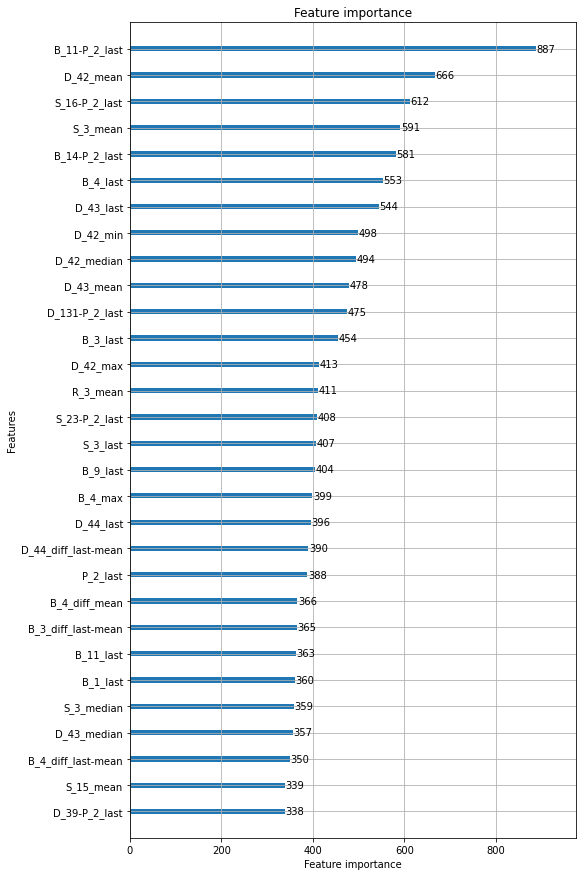

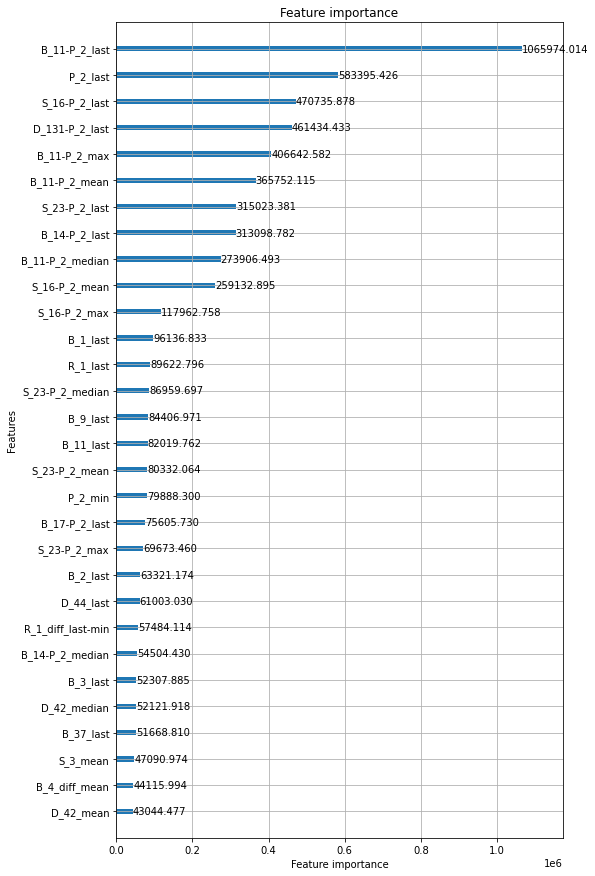

######################################## training model 4/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.759377	valid_0's recall_at4: 0.614349	valid_0's norm_gini: 0.904406


[100]	valid_0's amex_metric: 0.765124	valid_0's recall_at4: 0.621713	valid_0's norm_gini: 0.908536


[150]	valid_0's amex_metric: 0.770336	valid_0's recall_at4: 0.629708	valid_0's norm_gini: 0.910965


[200]	valid_0's amex_metric: 0.771794	valid_0's recall_at4: 0.631349	valid_0's norm_gini: 0.912239


[250]	valid_0's amex_metric: 0.77558	valid_0's recall_at4: 0.637071	valid_0's norm_gini: 0.914088


[300]	valid_0's amex_metric: 0.778272	valid_0's recall_at4: 0.641027	valid_0's norm_gini: 0.915518


[350]	valid_0's amex_metric: 0.779984	valid_0's recall_at4: 0.643593	valid_0's norm_gini: 0.916375


[400]	valid_0's amex_metric: 0.781339	valid_0's recall_at4: 0.645655	valid_0's norm_gini: 0.917022


[450]	valid_0's amex_metric: 0.784358	valid_0's recall_at4: 0.650663	valid_0's norm_gini: 0.918053


[500]	valid_0's amex_metric: 0.786673	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.919274


[550]	valid_0's amex_metric: 0.788986	valid_0's recall_at4: 0.657816	valid_0's norm_gini: 0.920156


[600]	valid_0's amex_metric: 0.790402	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.920926


[650]	valid_0's amex_metric: 0.790904	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.9213


[700]	valid_0's amex_metric: 0.791723	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.921801


[750]	valid_0's amex_metric: 0.792265	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.922042


[800]	valid_0's amex_metric: 0.792823	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.922317


[850]	valid_0's amex_metric: 0.793072	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.922479


[900]	valid_0's amex_metric: 0.793206	valid_0's recall_at4: 0.663665	valid_0's norm_gini: 0.922747


[950]	valid_0's amex_metric: 0.794018	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.923024


[1000]	valid_0's amex_metric: 0.794951	valid_0's recall_at4: 0.666611	valid_0's norm_gini: 0.923291


[1050]	valid_0's amex_metric: 0.794682	valid_0's recall_at4: 0.665727	valid_0's norm_gini: 0.923638


[1100]	valid_0's amex_metric: 0.794856	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.92386


[1150]	valid_0's amex_metric: 0.794974	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.924052


[1200]	valid_0's amex_metric: 0.796681	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.924142


[1250]	valid_0's amex_metric: 0.797165	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.924311


[1300]	valid_0's amex_metric: 0.796595	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.92435


[1350]	valid_0's amex_metric: 0.79721	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.924444


[1400]	valid_0's amex_metric: 0.797561	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.924555


[1450]	valid_0's amex_metric: 0.797736	valid_0's recall_at4: 0.670776	valid_0's norm_gini: 0.924695


[1500]	valid_0's amex_metric: 0.798091	valid_0's recall_at4: 0.671365	valid_0's norm_gini: 0.924817


[1550]	valid_0's amex_metric: 0.797497	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.924976


[1600]	valid_0's amex_metric: 0.797696	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.925078


[1650]	valid_0's amex_metric: 0.797676	valid_0's recall_at4: 0.670187	valid_0's norm_gini: 0.925165


[1700]	valid_0's amex_metric: 0.798143	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.925214


[1750]	valid_0's amex_metric: 0.798281	valid_0's recall_at4: 0.671239	valid_0's norm_gini: 0.925322


[1800]	valid_0's amex_metric: 0.798385	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.925447


[1850]	valid_0's amex_metric: 0.798715	valid_0's recall_at4: 0.671912	valid_0's norm_gini: 0.925518


[1900]	valid_0's amex_metric: 0.79899	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.925563


[1950]	valid_0's amex_metric: 0.799119	valid_0's recall_at4: 0.672628	valid_0's norm_gini: 0.92561


[2000]	valid_0's amex_metric: 0.799464	valid_0's recall_at4: 0.673259	valid_0's norm_gini: 0.925669


[2050]	valid_0's amex_metric: 0.799588	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.925749


[2100]	valid_0's amex_metric: 0.799783	valid_0's recall_at4: 0.673848	valid_0's norm_gini: 0.925718


[2150]	valid_0's amex_metric: 0.800061	valid_0's recall_at4: 0.674311	valid_0's norm_gini: 0.92581


[2200]	valid_0's amex_metric: 0.800495	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.925879


[2250]	valid_0's amex_metric: 0.800508	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.925906


[2300]	valid_0's amex_metric: 0.799761	valid_0's recall_at4: 0.673596	valid_0's norm_gini: 0.925927


[2350]	valid_0's amex_metric: 0.799949	valid_0's recall_at4: 0.673974	valid_0's norm_gini: 0.925924


[2400]	valid_0's amex_metric: 0.800747	valid_0's recall_at4: 0.675531	valid_0's norm_gini: 0.925962


[2450]	valid_0's amex_metric: 0.80065	valid_0's recall_at4: 0.675321	valid_0's norm_gini: 0.92598


[2500]	valid_0's amex_metric: 0.800417	valid_0's recall_at4: 0.674858	valid_0's norm_gini: 0.925977


[2550]	valid_0's amex_metric: 0.800227	valid_0's recall_at4: 0.674437	valid_0's norm_gini: 0.926018


[2600]	valid_0's amex_metric: 0.799982	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.926031


[2650]	valid_0's amex_metric: 0.799881	valid_0's recall_at4: 0.67368	valid_0's norm_gini: 0.926082


[2700]	valid_0's amex_metric: 0.800399	valid_0's recall_at4: 0.67469	valid_0's norm_gini: 0.926108


[2750]	valid_0's amex_metric: 0.800327	valid_0's recall_at4: 0.674521	valid_0's norm_gini: 0.926134


[2800]	valid_0's amex_metric: 0.800474	valid_0's recall_at4: 0.674816	valid_0's norm_gini: 0.926132


[2850]	valid_0's amex_metric: 0.80021	valid_0's recall_at4: 0.674227	valid_0's norm_gini: 0.926192


[2900]	valid_0's amex_metric: 0.80066	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.92621


[2950]	valid_0's amex_metric: 0.800903	valid_0's recall_at4: 0.675573	valid_0's norm_gini: 0.926233


[3000]	valid_0's amex_metric: 0.801185	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.92625


[3050]	valid_0's amex_metric: 0.801309	valid_0's recall_at4: 0.676373	valid_0's norm_gini: 0.926245


[3100]	valid_0's amex_metric: 0.801497	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.926285


[3150]	valid_0's amex_metric: 0.801467	valid_0's recall_at4: 0.676625	valid_0's norm_gini: 0.926309


[3200]	valid_0's amex_metric: 0.801161	valid_0's recall_at4: 0.676036	valid_0's norm_gini: 0.926285


[3250]	valid_0's amex_metric: 0.801308	valid_0's recall_at4: 0.676289	valid_0's norm_gini: 0.926327


[3300]	valid_0's amex_metric: 0.80157	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.926345


[3350]	valid_0's amex_metric: 0.801325	valid_0's recall_at4: 0.676331	valid_0's norm_gini: 0.92632


[3400]	valid_0's amex_metric: 0.802085	valid_0's recall_at4: 0.677846	valid_0's norm_gini: 0.926325


[3450]	valid_0's amex_metric: 0.801908	valid_0's recall_at4: 0.677467	valid_0's norm_gini: 0.926349


[3500]	valid_0's amex_metric: 0.801788	valid_0's recall_at4: 0.677256	valid_0's norm_gini: 0.92632


[3550]	valid_0's amex_metric: 0.801544	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.926295


[3600]	valid_0's amex_metric: 0.8017	valid_0's recall_at4: 0.67713	valid_0's norm_gini: 0.92627


[3650]	valid_0's amex_metric: 0.80141	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.926278


[3700]	valid_0's amex_metric: 0.80156	valid_0's recall_at4: 0.676836	valid_0's norm_gini: 0.926284


[3750]	valid_0's amex_metric: 0.801951	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.926268


[3800]	valid_0's amex_metric: 0.801439	valid_0's recall_at4: 0.676625	valid_0's norm_gini: 0.926252


[3850]	valid_0's amex_metric: 0.801534	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.926274


[3900]	valid_0's amex_metric: 0.80117	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.926262


[3950]	valid_0's amex_metric: 0.801719	valid_0's recall_at4: 0.677214	valid_0's norm_gini: 0.926224


[4000]	valid_0's amex_metric: 0.801555	valid_0's recall_at4: 0.676878	valid_0's norm_gini: 0.926232


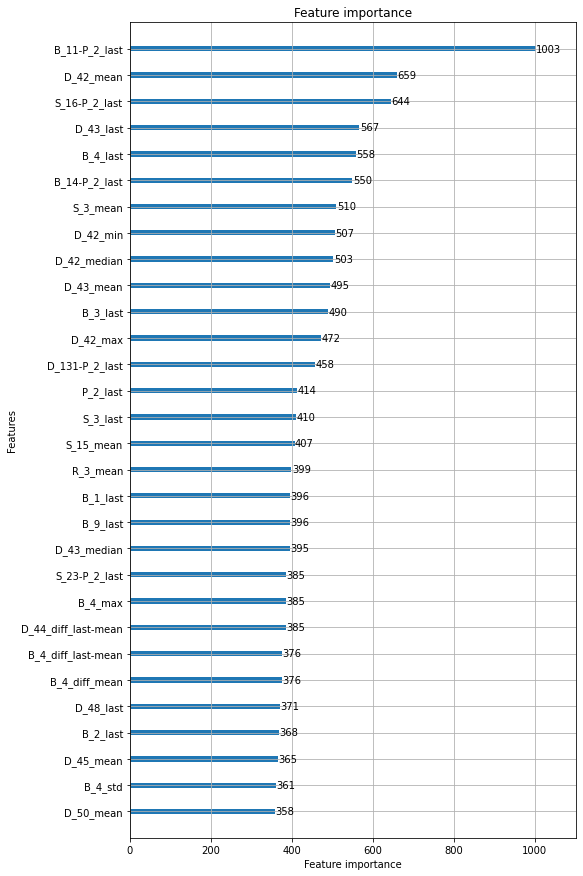

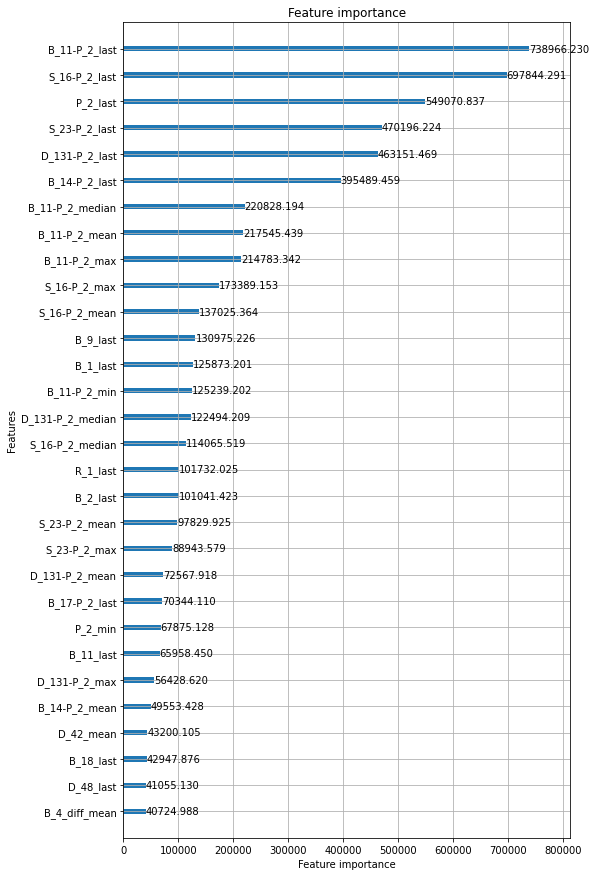

######################################## training model 5/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.758805	valid_0's recall_at4: 0.612834	valid_0's norm_gini: 0.904775


[100]	valid_0's amex_metric: 0.766089	valid_0's recall_at4: 0.623059	valid_0's norm_gini: 0.909118


[150]	valid_0's amex_metric: 0.769875	valid_0's recall_at4: 0.628403	valid_0's norm_gini: 0.911347


[200]	valid_0's amex_metric: 0.773212	valid_0's recall_at4: 0.633537	valid_0's norm_gini: 0.912887


[250]	valid_0's amex_metric: 0.776951	valid_0's recall_at4: 0.639344	valid_0's norm_gini: 0.914559


[300]	valid_0's amex_metric: 0.779749	valid_0's recall_at4: 0.643593	valid_0's norm_gini: 0.915904


[350]	valid_0's amex_metric: 0.780516	valid_0's recall_at4: 0.644309	valid_0's norm_gini: 0.916723


[400]	valid_0's amex_metric: 0.782109	valid_0's recall_at4: 0.646834	valid_0's norm_gini: 0.917384


[450]	valid_0's amex_metric: 0.783582	valid_0's recall_at4: 0.648769	valid_0's norm_gini: 0.918395


[500]	valid_0's amex_metric: 0.785356	valid_0's recall_at4: 0.65121	valid_0's norm_gini: 0.919502


[550]	valid_0's amex_metric: 0.787107	valid_0's recall_at4: 0.653777	valid_0's norm_gini: 0.920436


[600]	valid_0's amex_metric: 0.788934	valid_0's recall_at4: 0.656722	valid_0's norm_gini: 0.921146


[650]	valid_0's amex_metric: 0.789516	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.921596


[700]	valid_0's amex_metric: 0.790141	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.922087


[750]	valid_0's amex_metric: 0.7903	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.922321


[800]	valid_0's amex_metric: 0.790239	valid_0's recall_at4: 0.657816	valid_0's norm_gini: 0.922662


[850]	valid_0's amex_metric: 0.790567	valid_0's recall_at4: 0.658195	valid_0's norm_gini: 0.922938


[900]	valid_0's amex_metric: 0.7909	valid_0's recall_at4: 0.658616	valid_0's norm_gini: 0.923184


[950]	valid_0's amex_metric: 0.791689	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.923458


[1000]	valid_0's amex_metric: 0.791769	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.923743


[1050]	valid_0's amex_metric: 0.793147	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.924101


[1100]	valid_0's amex_metric: 0.793398	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.924308


[1150]	valid_0's amex_metric: 0.793741	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924448


[1200]	valid_0's amex_metric: 0.793617	valid_0's recall_at4: 0.662655	valid_0's norm_gini: 0.924579


[1250]	valid_0's amex_metric: 0.794009	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.924732


[1300]	valid_0's amex_metric: 0.794623	valid_0's recall_at4: 0.664465	valid_0's norm_gini: 0.924782


[1350]	valid_0's amex_metric: 0.794245	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924867


[1400]	valid_0's amex_metric: 0.79456	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924992


[1450]	valid_0's amex_metric: 0.795119	valid_0's recall_at4: 0.665096	valid_0's norm_gini: 0.925143


[1500]	valid_0's amex_metric: 0.794856	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.925205


[1550]	valid_0's amex_metric: 0.795303	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.925383


[1600]	valid_0's amex_metric: 0.795683	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.925472


[1650]	valid_0's amex_metric: 0.794494	valid_0's recall_at4: 0.663455	valid_0's norm_gini: 0.925533


[1700]	valid_0's amex_metric: 0.794894	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.925576


[1750]	valid_0's amex_metric: 0.795365	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.925677


[1800]	valid_0's amex_metric: 0.795504	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.925744


[1850]	valid_0's amex_metric: 0.795963	valid_0's recall_at4: 0.666106	valid_0's norm_gini: 0.925821


[1900]	valid_0's amex_metric: 0.796645	valid_0's recall_at4: 0.667452	valid_0's norm_gini: 0.925837


[1950]	valid_0's amex_metric: 0.796601	valid_0's recall_at4: 0.667326	valid_0's norm_gini: 0.925876


[2000]	valid_0's amex_metric: 0.796521	valid_0's recall_at4: 0.667116	valid_0's norm_gini: 0.925926


[2050]	valid_0's amex_metric: 0.797297	valid_0's recall_at4: 0.668588	valid_0's norm_gini: 0.926006


[2100]	valid_0's amex_metric: 0.797513	valid_0's recall_at4: 0.668967	valid_0's norm_gini: 0.926058


[2150]	valid_0's amex_metric: 0.797879	valid_0's recall_at4: 0.66964	valid_0's norm_gini: 0.926118


[2200]	valid_0's amex_metric: 0.798374	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.926183


[2250]	valid_0's amex_metric: 0.798557	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.926211


[2300]	valid_0's amex_metric: 0.798397	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.926228


[2350]	valid_0's amex_metric: 0.798777	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.926232


[2400]	valid_0's amex_metric: 0.798973	valid_0's recall_at4: 0.671702	valid_0's norm_gini: 0.926244


[2450]	valid_0's amex_metric: 0.799124	valid_0's recall_at4: 0.671997	valid_0's norm_gini: 0.926251


[2500]	valid_0's amex_metric: 0.799244	valid_0's recall_at4: 0.672207	valid_0's norm_gini: 0.92628


[2550]	valid_0's amex_metric: 0.79882	valid_0's recall_at4: 0.671365	valid_0's norm_gini: 0.926275


[2600]	valid_0's amex_metric: 0.798686	valid_0's recall_at4: 0.671071	valid_0's norm_gini: 0.926301


[2650]	valid_0's amex_metric: 0.798968	valid_0's recall_at4: 0.671618	valid_0's norm_gini: 0.926318


[2700]	valid_0's amex_metric: 0.798744	valid_0's recall_at4: 0.671197	valid_0's norm_gini: 0.926291


[2750]	valid_0's amex_metric: 0.798918	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.926345


[2800]	valid_0's amex_metric: 0.799536	valid_0's recall_at4: 0.672712	valid_0's norm_gini: 0.92636


[2850]	valid_0's amex_metric: 0.799952	valid_0's recall_at4: 0.673511	valid_0's norm_gini: 0.926392


[2900]	valid_0's amex_metric: 0.800074	valid_0's recall_at4: 0.673722	valid_0's norm_gini: 0.926427


[2950]	valid_0's amex_metric: 0.800019	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.9264


[3000]	valid_0's amex_metric: 0.800013	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.926388


[3050]	valid_0's amex_metric: 0.799964	valid_0's recall_at4: 0.673554	valid_0's norm_gini: 0.926375


[3100]	valid_0's amex_metric: 0.799509	valid_0's recall_at4: 0.672628	valid_0's norm_gini: 0.92639


[3150]	valid_0's amex_metric: 0.79985	valid_0's recall_at4: 0.673301	valid_0's norm_gini: 0.926399


[3200]	valid_0's amex_metric: 0.799545	valid_0's recall_at4: 0.672712	valid_0's norm_gini: 0.926378


[3250]	valid_0's amex_metric: 0.79935	valid_0's recall_at4: 0.672291	valid_0's norm_gini: 0.926408


[3300]	valid_0's amex_metric: 0.799355	valid_0's recall_at4: 0.672333	valid_0's norm_gini: 0.926376


[3350]	valid_0's amex_metric: 0.799275	valid_0's recall_at4: 0.672165	valid_0's norm_gini: 0.926386


[3400]	valid_0's amex_metric: 0.799525	valid_0's recall_at4: 0.67267	valid_0's norm_gini: 0.92638


[3450]	valid_0's amex_metric: 0.799905	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926382


[3500]	valid_0's amex_metric: 0.799659	valid_0's recall_at4: 0.672922	valid_0's norm_gini: 0.926395


[3550]	valid_0's amex_metric: 0.799847	valid_0's recall_at4: 0.673301	valid_0's norm_gini: 0.926393


[3600]	valid_0's amex_metric: 0.799873	valid_0's recall_at4: 0.673343	valid_0's norm_gini: 0.926404


[3650]	valid_0's amex_metric: 0.799502	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.926418


[3700]	valid_0's amex_metric: 0.80014	valid_0's recall_at4: 0.673848	valid_0's norm_gini: 0.926432


[3750]	valid_0's amex_metric: 0.799984	valid_0's recall_at4: 0.673511	valid_0's norm_gini: 0.926456


[3800]	valid_0's amex_metric: 0.800023	valid_0's recall_at4: 0.673596	valid_0's norm_gini: 0.926451


[3850]	valid_0's amex_metric: 0.800488	valid_0's recall_at4: 0.674521	valid_0's norm_gini: 0.926455


[3900]	valid_0's amex_metric: 0.800277	valid_0's recall_at4: 0.674101	valid_0's norm_gini: 0.926454


[3950]	valid_0's amex_metric: 0.799966	valid_0's recall_at4: 0.673469	valid_0's norm_gini: 0.926463


[4000]	valid_0's amex_metric: 0.800214	valid_0's recall_at4: 0.673974	valid_0's norm_gini: 0.926455


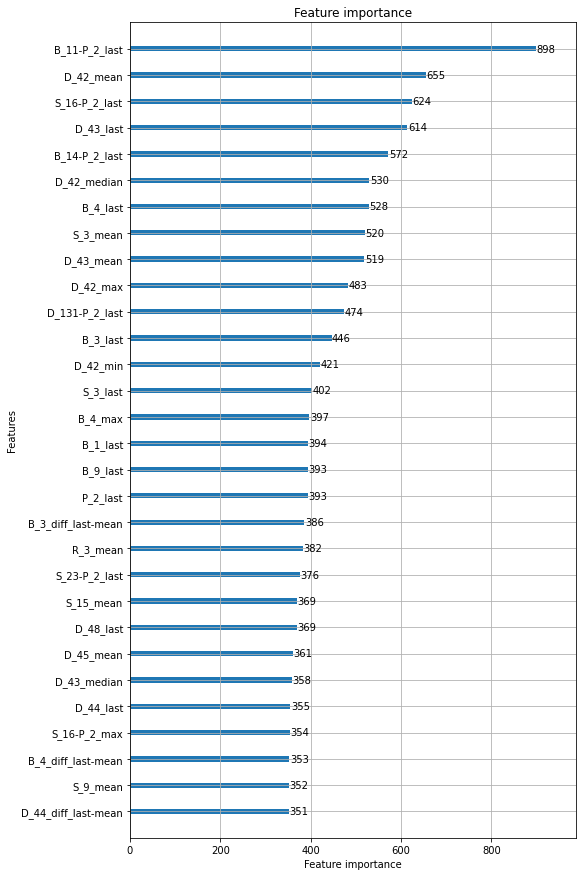

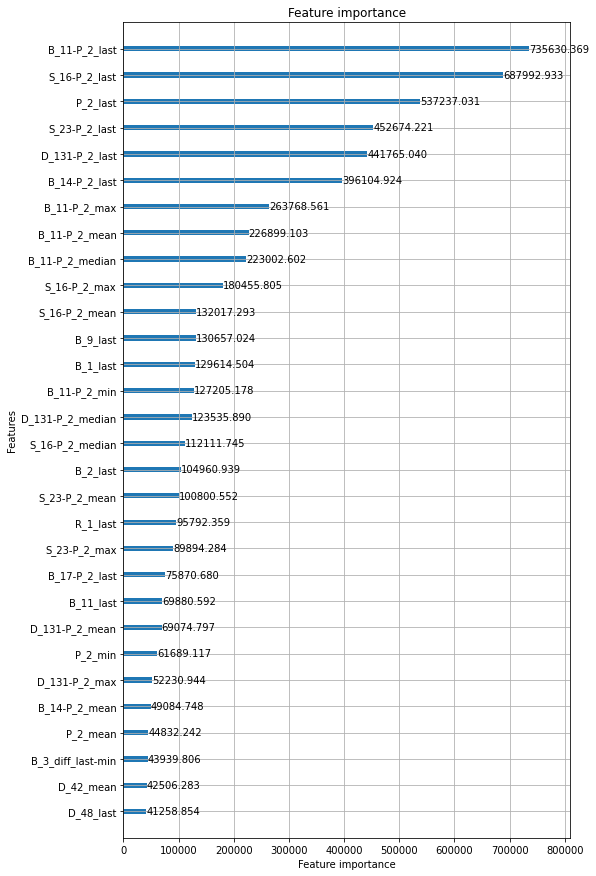

Training time: 98.92521597146988 min.
OOF recall_at4: 0.6718113575924867
OOF normalized_gini: 0.9259368532884505
OOF competition metric: 0.7988741054404687


############################### repeated cross-validation step: 3/3 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.754229	valid_0's recall_at4: 0.605697	valid_0's norm_gini: 0.90276


[100]	valid_0's amex_metric: 0.761155	valid_0's recall_at4: 0.615459	valid_0's norm_gini: 0.906851


[150]	valid_0's amex_metric: 0.764587	valid_0's recall_at4: 0.620003	valid_0's norm_gini: 0.90917


[200]	valid_0's amex_metric: 0.767739	valid_0's recall_at4: 0.624968	valid_0's norm_gini: 0.910509


[250]	valid_0's amex_metric: 0.771003	valid_0's recall_at4: 0.629639	valid_0's norm_gini: 0.912366


[300]	valid_0's amex_metric: 0.772928	valid_0's recall_at4: 0.631953	valid_0's norm_gini: 0.913902


[350]	valid_0's amex_metric: 0.775415	valid_0's recall_at4: 0.636035	valid_0's norm_gini: 0.914796


[400]	valid_0's amex_metric: 0.776722	valid_0's recall_at4: 0.63797	valid_0's norm_gini: 0.915475


[450]	valid_0's amex_metric: 0.777787	valid_0's recall_at4: 0.639022	valid_0's norm_gini: 0.916553


[500]	valid_0's amex_metric: 0.781001	valid_0's recall_at4: 0.644324	valid_0's norm_gini: 0.917679


[550]	valid_0's amex_metric: 0.782919	valid_0's recall_at4: 0.647227	valid_0's norm_gini: 0.918611


[600]	valid_0's amex_metric: 0.785035	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.919392


[650]	valid_0's amex_metric: 0.785551	valid_0's recall_at4: 0.651309	valid_0's norm_gini: 0.919793


[700]	valid_0's amex_metric: 0.787316	valid_0's recall_at4: 0.65438	valid_0's norm_gini: 0.920251


[750]	valid_0's amex_metric: 0.787628	valid_0's recall_at4: 0.654759	valid_0's norm_gini: 0.920498


[800]	valid_0's amex_metric: 0.788984	valid_0's recall_at4: 0.657157	valid_0's norm_gini: 0.920811


[850]	valid_0's amex_metric: 0.788427	valid_0's recall_at4: 0.655769	valid_0's norm_gini: 0.921084


[900]	valid_0's amex_metric: 0.788596	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.92134


[950]	valid_0's amex_metric: 0.789051	valid_0's recall_at4: 0.656484	valid_0's norm_gini: 0.921618


[1000]	valid_0's amex_metric: 0.789205	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.921842


[1050]	valid_0's amex_metric: 0.790136	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.922147


[1100]	valid_0's amex_metric: 0.791056	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.922346


[1150]	valid_0's amex_metric: 0.791643	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.92251


[1200]	valid_0's amex_metric: 0.79206	valid_0's recall_at4: 0.661449	valid_0's norm_gini: 0.922671


[1250]	valid_0's amex_metric: 0.79194	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.92281


[1300]	valid_0's amex_metric: 0.792366	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.922862


[1350]	valid_0's amex_metric: 0.792333	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.922923


[1400]	valid_0's amex_metric: 0.792138	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.923037


[1450]	valid_0's amex_metric: 0.792946	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.923139


[1500]	valid_0's amex_metric: 0.793035	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.923233


[1550]	valid_0's amex_metric: 0.793533	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.923346


[1600]	valid_0's amex_metric: 0.793453	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.923438


[1650]	valid_0's amex_metric: 0.793476	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.923526


[1700]	valid_0's amex_metric: 0.79422	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.923624


[1750]	valid_0's amex_metric: 0.794689	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.92368


[1800]	valid_0's amex_metric: 0.794315	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.923773


[1850]	valid_0's amex_metric: 0.794341	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.923867


[1900]	valid_0's amex_metric: 0.794126	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.9239


[1950]	valid_0's amex_metric: 0.794448	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.923912


[2000]	valid_0's amex_metric: 0.794241	valid_0's recall_at4: 0.664521	valid_0's norm_gini: 0.923961


[2050]	valid_0's amex_metric: 0.794192	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.92399


[2100]	valid_0's amex_metric: 0.794095	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.924005


[2150]	valid_0's amex_metric: 0.794177	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.924043


[2200]	valid_0's amex_metric: 0.794468	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.924078


[2250]	valid_0's amex_metric: 0.794236	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.924078


[2300]	valid_0's amex_metric: 0.794536	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924089


[2350]	valid_0's amex_metric: 0.795411	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924071


[2400]	valid_0's amex_metric: 0.794852	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924088


[2450]	valid_0's amex_metric: 0.794863	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924111


[2500]	valid_0's amex_metric: 0.794958	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924091


[2550]	valid_0's amex_metric: 0.795083	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.924131


[2600]	valid_0's amex_metric: 0.795008	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924149


[2650]	valid_0's amex_metric: 0.794914	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.924129


[2700]	valid_0's amex_metric: 0.794459	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924145


[2750]	valid_0's amex_metric: 0.794717	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.924156


[2800]	valid_0's amex_metric: 0.795578	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.924152


[2850]	valid_0's amex_metric: 0.795408	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924149


[2900]	valid_0's amex_metric: 0.794988	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924152


[2950]	valid_0's amex_metric: 0.795037	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.924166


[3000]	valid_0's amex_metric: 0.795661	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.924193


[3050]	valid_0's amex_metric: 0.795859	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.92421


[3100]	valid_0's amex_metric: 0.795959	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.924158


[3150]	valid_0's amex_metric: 0.796145	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.924193


[3200]	valid_0's amex_metric: 0.795762	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.924184


[3250]	valid_0's amex_metric: 0.795824	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.924182


[3300]	valid_0's amex_metric: 0.795261	valid_0's recall_at4: 0.66633	valid_0's norm_gini: 0.924192


[3350]	valid_0's amex_metric: 0.795216	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.924187


[3400]	valid_0's amex_metric: 0.795363	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.924185


[3450]	valid_0's amex_metric: 0.795722	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.924231


[3500]	valid_0's amex_metric: 0.795484	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924218


[3550]	valid_0's amex_metric: 0.795631	valid_0's recall_at4: 0.667003	valid_0's norm_gini: 0.924259


[3600]	valid_0's amex_metric: 0.7955	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924249


[3650]	valid_0's amex_metric: 0.795368	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.924237


[3700]	valid_0's amex_metric: 0.795852	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.924238


[3750]	valid_0's amex_metric: 0.795707	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.924242


[3800]	valid_0's amex_metric: 0.795392	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.924244


[3850]	valid_0's amex_metric: 0.794959	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.924262


[3900]	valid_0's amex_metric: 0.795046	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924268


[3950]	valid_0's amex_metric: 0.795272	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.924257


[4000]	valid_0's amex_metric: 0.795391	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.924242


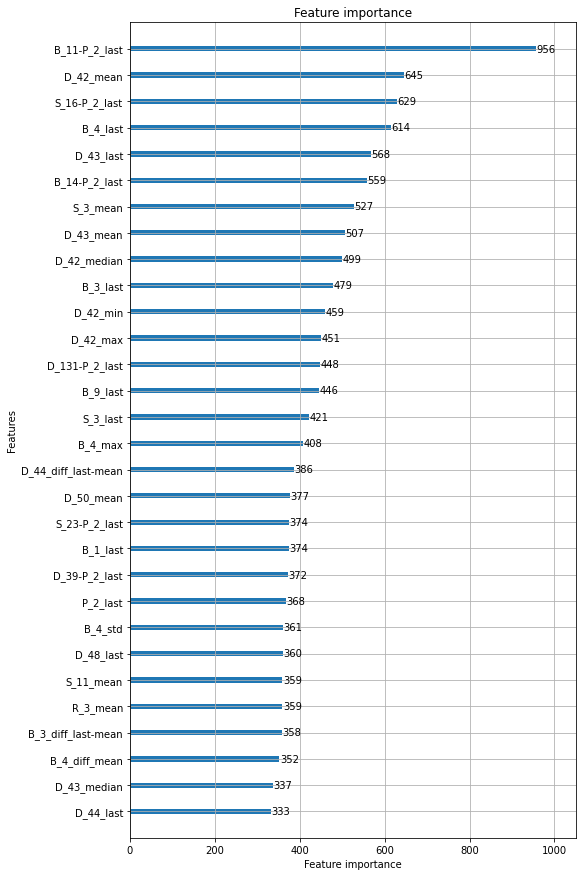

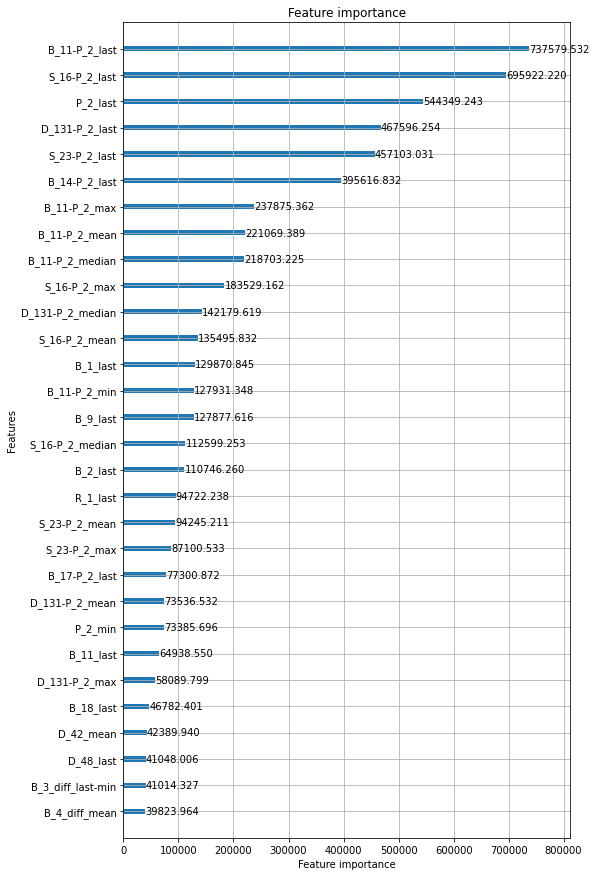

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.754127	valid_0's recall_at4: 0.604351	valid_0's norm_gini: 0.903903


[100]	valid_0's amex_metric: 0.761665	valid_0's recall_at4: 0.615375	valid_0's norm_gini: 0.907955


[150]	valid_0's amex_metric: 0.76491	valid_0's recall_at4: 0.619583	valid_0's norm_gini: 0.910237


[200]	valid_0's amex_metric: 0.767629	valid_0's recall_at4: 0.623664	valid_0's norm_gini: 0.911594


[250]	valid_0's amex_metric: 0.769907	valid_0's recall_at4: 0.626525	valid_0's norm_gini: 0.913289


[300]	valid_0's amex_metric: 0.773014	valid_0's recall_at4: 0.631364	valid_0's norm_gini: 0.914664


[350]	valid_0's amex_metric: 0.774329	valid_0's recall_at4: 0.633047	valid_0's norm_gini: 0.91561


[400]	valid_0's amex_metric: 0.775682	valid_0's recall_at4: 0.635067	valid_0's norm_gini: 0.916298


[450]	valid_0's amex_metric: 0.777464	valid_0's recall_at4: 0.637507	valid_0's norm_gini: 0.917422


[500]	valid_0's amex_metric: 0.779411	valid_0's recall_at4: 0.640326	valid_0's norm_gini: 0.918495


[550]	valid_0's amex_metric: 0.781567	valid_0's recall_at4: 0.643693	valid_0's norm_gini: 0.919442


[600]	valid_0's amex_metric: 0.783081	valid_0's recall_at4: 0.645923	valid_0's norm_gini: 0.920239


[650]	valid_0's amex_metric: 0.784396	valid_0's recall_at4: 0.648153	valid_0's norm_gini: 0.92064


[700]	valid_0's amex_metric: 0.785157	valid_0's recall_at4: 0.649163	valid_0's norm_gini: 0.921151


[750]	valid_0's amex_metric: 0.785993	valid_0's recall_at4: 0.650509	valid_0's norm_gini: 0.921478


[800]	valid_0's amex_metric: 0.786088	valid_0's recall_at4: 0.650383	valid_0's norm_gini: 0.921793


[850]	valid_0's amex_metric: 0.786725	valid_0's recall_at4: 0.651309	valid_0's norm_gini: 0.922142


[900]	valid_0's amex_metric: 0.786851	valid_0's recall_at4: 0.651309	valid_0's norm_gini: 0.922393


[950]	valid_0's amex_metric: 0.78792	valid_0's recall_at4: 0.653118	valid_0's norm_gini: 0.922722


[1000]	valid_0's amex_metric: 0.788686	valid_0's recall_at4: 0.654338	valid_0's norm_gini: 0.923034


[1050]	valid_0's amex_metric: 0.788984	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.92342


[1100]	valid_0's amex_metric: 0.789165	valid_0's recall_at4: 0.654717	valid_0's norm_gini: 0.923614


[1150]	valid_0's amex_metric: 0.789746	valid_0's recall_at4: 0.655685	valid_0's norm_gini: 0.923808


[1200]	valid_0's amex_metric: 0.790099	valid_0's recall_at4: 0.656274	valid_0's norm_gini: 0.923924


[1250]	valid_0's amex_metric: 0.790505	valid_0's recall_at4: 0.656947	valid_0's norm_gini: 0.924063


[1300]	valid_0's amex_metric: 0.791051	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.924144


[1350]	valid_0's amex_metric: 0.790855	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.924258


[1400]	valid_0's amex_metric: 0.790969	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.924359


[1450]	valid_0's amex_metric: 0.791392	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.924449


[1500]	valid_0's amex_metric: 0.791635	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.924514


[1550]	valid_0's amex_metric: 0.791778	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.924673


[1600]	valid_0's amex_metric: 0.791756	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.924756


[1650]	valid_0's amex_metric: 0.791978	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.924821


[1700]	valid_0's amex_metric: 0.792989	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.924907


[1750]	valid_0's amex_metric: 0.792727	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.924973


[1800]	valid_0's amex_metric: 0.792558	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.925056


[1850]	valid_0's amex_metric: 0.792899	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.925149


[1900]	valid_0's amex_metric: 0.792978	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.925181


[1950]	valid_0's amex_metric: 0.793156	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.925242


[2000]	valid_0's amex_metric: 0.793095	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.92533


[2050]	valid_0's amex_metric: 0.793281	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.925365


[2100]	valid_0's amex_metric: 0.794633	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.925461


[2150]	valid_0's amex_metric: 0.794904	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.925539


[2200]	valid_0's amex_metric: 0.794604	valid_0's recall_at4: 0.663637	valid_0's norm_gini: 0.92557


[2250]	valid_0's amex_metric: 0.794549	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.925587


[2300]	valid_0's amex_metric: 0.794566	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.925621


[2350]	valid_0's amex_metric: 0.794219	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.925643


[2400]	valid_0's amex_metric: 0.794492	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925683


[2450]	valid_0's amex_metric: 0.794524	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.925706


[2500]	valid_0's amex_metric: 0.794546	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.925707


[2550]	valid_0's amex_metric: 0.7946	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.925689


[2600]	valid_0's amex_metric: 0.793831	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.925709


[2650]	valid_0's amex_metric: 0.794295	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.92571


[2700]	valid_0's amex_metric: 0.794553	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.925763


[2750]	valid_0's amex_metric: 0.793706	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.925795


[2800]	valid_0's amex_metric: 0.794347	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.925815


[2850]	valid_0's amex_metric: 0.794785	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.925849


[2900]	valid_0's amex_metric: 0.794852	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.925857


[2950]	valid_0's amex_metric: 0.795003	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925865


[3000]	valid_0's amex_metric: 0.794231	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.925877


[3050]	valid_0's amex_metric: 0.794097	valid_0's recall_at4: 0.662333	valid_0's norm_gini: 0.925862


[3100]	valid_0's amex_metric: 0.794482	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.925875


[3150]	valid_0's amex_metric: 0.794713	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.925873


[3200]	valid_0's amex_metric: 0.794249	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.925912


[3250]	valid_0's amex_metric: 0.794582	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.925948


[3300]	valid_0's amex_metric: 0.794285	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.925944


[3350]	valid_0's amex_metric: 0.794055	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.925904


[3400]	valid_0's amex_metric: 0.794314	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.925916


[3450]	valid_0's amex_metric: 0.79461	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.925919


[3500]	valid_0's amex_metric: 0.794843	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.925923


[3550]	valid_0's amex_metric: 0.795385	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.925913


[3600]	valid_0's amex_metric: 0.795296	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.925902


[3650]	valid_0's amex_metric: 0.795249	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.925936


[3700]	valid_0's amex_metric: 0.796303	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.92594


[3750]	valid_0's amex_metric: 0.796043	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.925925


[3800]	valid_0's amex_metric: 0.795955	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.925959


[3850]	valid_0's amex_metric: 0.795576	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.926


[3900]	valid_0's amex_metric: 0.795615	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.925995


[3950]	valid_0's amex_metric: 0.795385	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.925997


[4000]	valid_0's amex_metric: 0.79501	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.926004


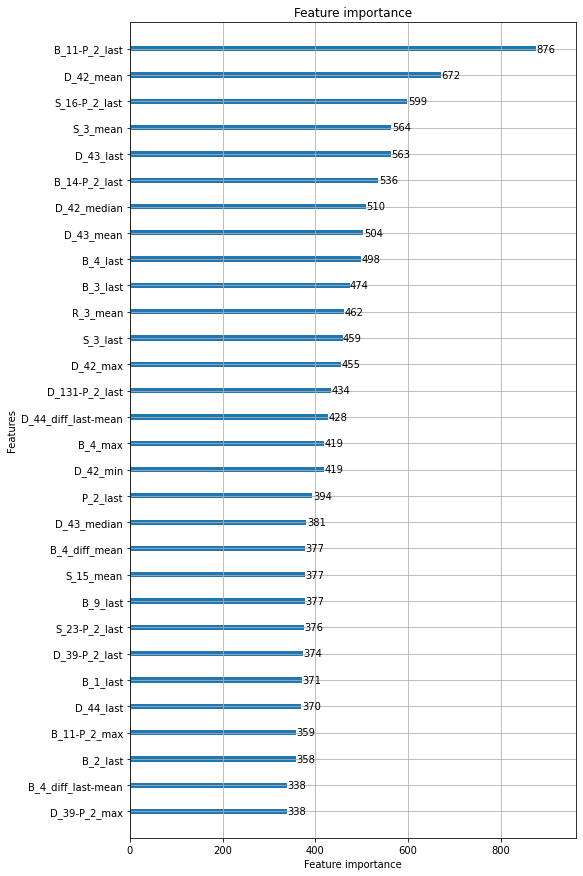

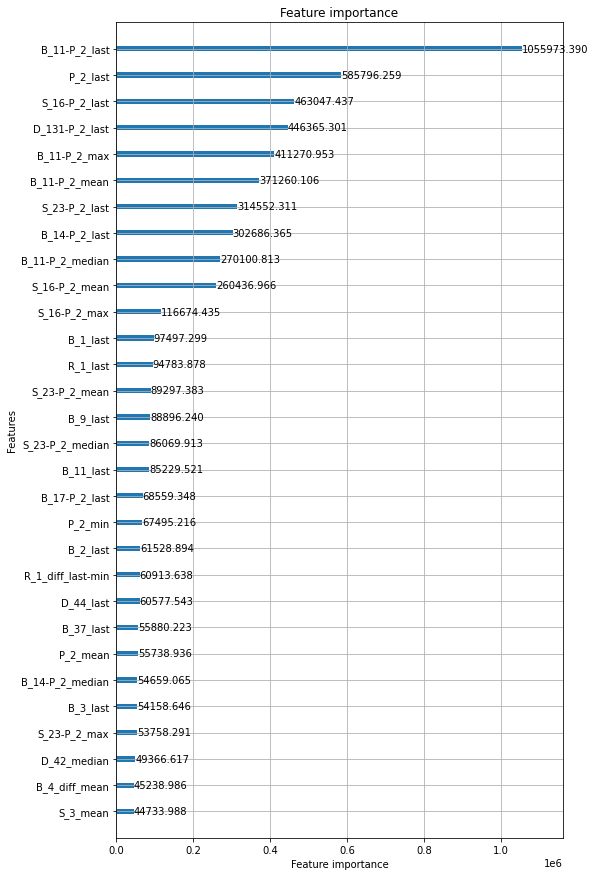

######################################## training model 3/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.756517	valid_0's recall_at4: 0.61062	valid_0's norm_gini: 0.902413


[100]	valid_0's amex_metric: 0.764604	valid_0's recall_at4: 0.622318	valid_0's norm_gini: 0.90689


[150]	valid_0's amex_metric: 0.769114	valid_0's recall_at4: 0.628797	valid_0's norm_gini: 0.909431


[200]	valid_0's amex_metric: 0.77143	valid_0's recall_at4: 0.632079	valid_0's norm_gini: 0.91078


[250]	valid_0's amex_metric: 0.774756	valid_0's recall_at4: 0.63675	valid_0's norm_gini: 0.912762


[300]	valid_0's amex_metric: 0.777207	valid_0's recall_at4: 0.640158	valid_0's norm_gini: 0.914255


[350]	valid_0's amex_metric: 0.779123	valid_0's recall_at4: 0.643104	valid_0's norm_gini: 0.915143


[400]	valid_0's amex_metric: 0.77931	valid_0's recall_at4: 0.642725	valid_0's norm_gini: 0.915895


[450]	valid_0's amex_metric: 0.78221	valid_0's recall_at4: 0.647353	valid_0's norm_gini: 0.917067


[500]	valid_0's amex_metric: 0.784531	valid_0's recall_at4: 0.650846	valid_0's norm_gini: 0.918217


[550]	valid_0's amex_metric: 0.787019	valid_0's recall_at4: 0.654675	valid_0's norm_gini: 0.919364


[600]	valid_0's amex_metric: 0.788334	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.920269


[650]	valid_0's amex_metric: 0.789242	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.920696


[700]	valid_0's amex_metric: 0.791165	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.921218


[750]	valid_0's amex_metric: 0.791767	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.921538


[800]	valid_0's amex_metric: 0.792049	valid_0's recall_at4: 0.662207	valid_0's norm_gini: 0.921891


[850]	valid_0's amex_metric: 0.792464	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.922217


[900]	valid_0's amex_metric: 0.792786	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.922523


[950]	valid_0's amex_metric: 0.793649	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.922903


[1000]	valid_0's amex_metric: 0.794701	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.923199


[1050]	valid_0's amex_metric: 0.79573	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.923573


[1100]	valid_0's amex_metric: 0.795963	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.923828


[1150]	valid_0's amex_metric: 0.796049	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.924


[1200]	valid_0's amex_metric: 0.795964	valid_0's recall_at4: 0.667803	valid_0's norm_gini: 0.924124


[1250]	valid_0's amex_metric: 0.796696	valid_0's recall_at4: 0.669065	valid_0's norm_gini: 0.924326


[1300]	valid_0's amex_metric: 0.796612	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.92437


[1350]	valid_0's amex_metric: 0.796904	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.924449


[1400]	valid_0's amex_metric: 0.796764	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.924631


[1450]	valid_0's amex_metric: 0.797763	valid_0's recall_at4: 0.670748	valid_0's norm_gini: 0.924777


[1500]	valid_0's amex_metric: 0.797314	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.924889


[1550]	valid_0's amex_metric: 0.797709	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.92509


[1600]	valid_0's amex_metric: 0.797624	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925216


[1650]	valid_0's amex_metric: 0.798098	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925322


[1700]	valid_0's amex_metric: 0.797869	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.925368


[1750]	valid_0's amex_metric: 0.798297	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925425


[1800]	valid_0's amex_metric: 0.798414	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.92549


[1850]	valid_0's amex_metric: 0.798208	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.925585


[1900]	valid_0's amex_metric: 0.798255	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925551


[1950]	valid_0's amex_metric: 0.798264	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.92557


[2000]	valid_0's amex_metric: 0.798395	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925621


[2050]	valid_0's amex_metric: 0.799008	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925753


[2100]	valid_0's amex_metric: 0.798895	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925864


[2150]	valid_0's amex_metric: 0.799124	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925984


[2200]	valid_0's amex_metric: 0.799367	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926009


[2250]	valid_0's amex_metric: 0.799471	valid_0's recall_at4: 0.672894	valid_0's norm_gini: 0.926048


[2300]	valid_0's amex_metric: 0.798932	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.926023


[2350]	valid_0's amex_metric: 0.799222	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926014


[2400]	valid_0's amex_metric: 0.799102	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926024


[2450]	valid_0's amex_metric: 0.799804	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.92604


[2500]	valid_0's amex_metric: 0.799909	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.92604


[2550]	valid_0's amex_metric: 0.800283	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.92603


[2600]	valid_0's amex_metric: 0.800369	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.926035


[2650]	valid_0's amex_metric: 0.80009	valid_0's recall_at4: 0.674114	valid_0's norm_gini: 0.926066


[2700]	valid_0's amex_metric: 0.799538	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.926097


[2750]	valid_0's amex_metric: 0.799327	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926096


[2800]	valid_0's amex_metric: 0.799051	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926092


[2850]	valid_0's amex_metric: 0.799228	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.92611


[2900]	valid_0's amex_metric: 0.799333	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926108


[2950]	valid_0's amex_metric: 0.799871	valid_0's recall_at4: 0.673651	valid_0's norm_gini: 0.926091


[3000]	valid_0's amex_metric: 0.799979	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.926096


[3050]	valid_0's amex_metric: 0.799894	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.926095


[3100]	valid_0's amex_metric: 0.800363	valid_0's recall_at4: 0.674619	valid_0's norm_gini: 0.926107


[3150]	valid_0's amex_metric: 0.800029	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.926112


[3200]	valid_0's amex_metric: 0.799268	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926104


[3250]	valid_0's amex_metric: 0.799807	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.92609


[3300]	valid_0's amex_metric: 0.799636	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.926084


[3350]	valid_0's amex_metric: 0.800147	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926054


[3400]	valid_0's amex_metric: 0.800135	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926029


[3450]	valid_0's amex_metric: 0.800016	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.926044


[3500]	valid_0's amex_metric: 0.800689	valid_0's recall_at4: 0.675335	valid_0's norm_gini: 0.926043


[3550]	valid_0's amex_metric: 0.800724	valid_0's recall_at4: 0.675419	valid_0's norm_gini: 0.926028


[3600]	valid_0's amex_metric: 0.800626	valid_0's recall_at4: 0.675208	valid_0's norm_gini: 0.926043


[3650]	valid_0's amex_metric: 0.800336	valid_0's recall_at4: 0.674619	valid_0's norm_gini: 0.926053


[3700]	valid_0's amex_metric: 0.800429	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.926071


[3750]	valid_0's amex_metric: 0.800057	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.926041


[3800]	valid_0's amex_metric: 0.800608	valid_0's recall_at4: 0.675166	valid_0's norm_gini: 0.926049


[3850]	valid_0's amex_metric: 0.800274	valid_0's recall_at4: 0.674493	valid_0's norm_gini: 0.926055


[3900]	valid_0's amex_metric: 0.800368	valid_0's recall_at4: 0.674703	valid_0's norm_gini: 0.926032


[3950]	valid_0's amex_metric: 0.799807	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.926005


[4000]	valid_0's amex_metric: 0.799392	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.925974


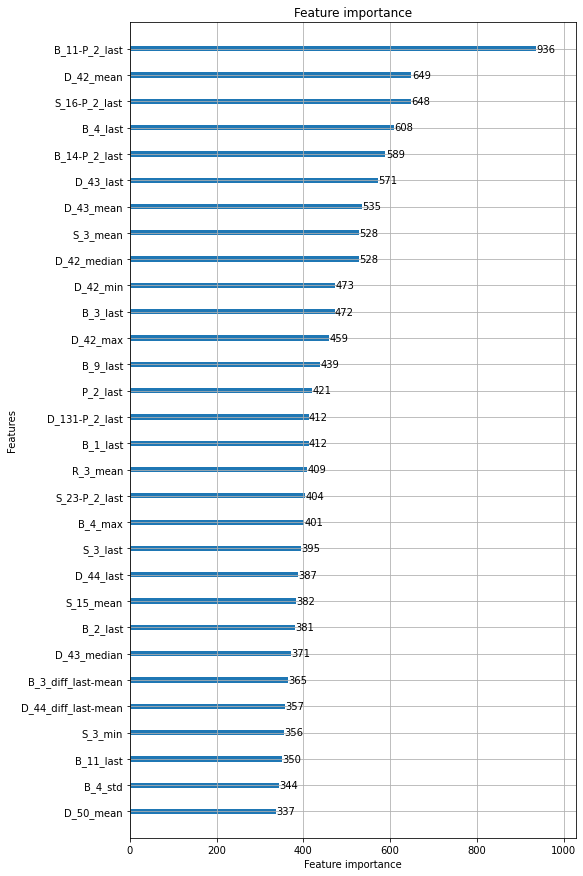

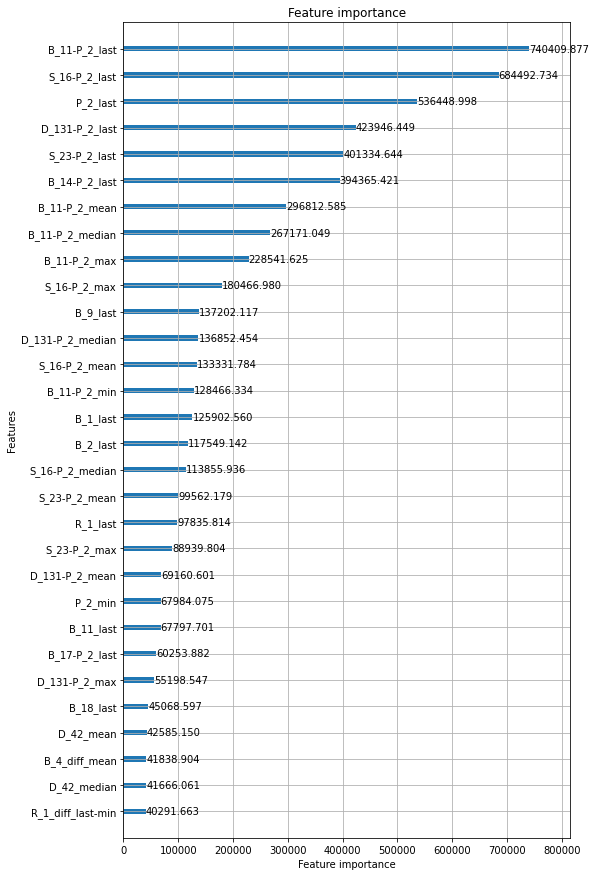

######################################## training model 4/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.760702	valid_0's recall_at4: 0.614812	valid_0's norm_gini: 0.906592


[100]	valid_0's amex_metric: 0.769821	valid_0's recall_at4: 0.628487	valid_0's norm_gini: 0.911154


[150]	valid_0's amex_metric: 0.773416	valid_0's recall_at4: 0.633495	valid_0's norm_gini: 0.913337


[200]	valid_0's amex_metric: 0.77524	valid_0's recall_at4: 0.635809	valid_0's norm_gini: 0.914672


[250]	valid_0's amex_metric: 0.779003	valid_0's recall_at4: 0.641532	valid_0's norm_gini: 0.916474


[300]	valid_0's amex_metric: 0.782224	valid_0's recall_at4: 0.646455	valid_0's norm_gini: 0.917993


[350]	valid_0's amex_metric: 0.78394	valid_0's recall_at4: 0.649022	valid_0's norm_gini: 0.918859


[400]	valid_0's amex_metric: 0.785221	valid_0's recall_at4: 0.650999	valid_0's norm_gini: 0.919443


[450]	valid_0's amex_metric: 0.7878	valid_0's recall_at4: 0.655123	valid_0's norm_gini: 0.920477


[500]	valid_0's amex_metric: 0.789698	valid_0's recall_at4: 0.657732	valid_0's norm_gini: 0.921663


[550]	valid_0's amex_metric: 0.791703	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.922687


[600]	valid_0's amex_metric: 0.793758	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.923556


[650]	valid_0's amex_metric: 0.794596	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.92397


[700]	valid_0's amex_metric: 0.796268	valid_0's recall_at4: 0.668083	valid_0's norm_gini: 0.924453


[750]	valid_0's amex_metric: 0.796265	valid_0's recall_at4: 0.667789	valid_0's norm_gini: 0.924741


[800]	valid_0's amex_metric: 0.7967	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.925149


[850]	valid_0's amex_metric: 0.796601	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.925456


[900]	valid_0's amex_metric: 0.797621	valid_0's recall_at4: 0.669556	valid_0's norm_gini: 0.925686


[950]	valid_0's amex_metric: 0.798508	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.92603


[1000]	valid_0's amex_metric: 0.798398	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.926356


[1050]	valid_0's amex_metric: 0.798821	valid_0's recall_at4: 0.670945	valid_0's norm_gini: 0.926697


[1100]	valid_0's amex_metric: 0.799556	valid_0's recall_at4: 0.672165	valid_0's norm_gini: 0.926947


[1150]	valid_0's amex_metric: 0.799405	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.927066


[1200]	valid_0's amex_metric: 0.7998	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.927182


[1250]	valid_0's amex_metric: 0.800556	valid_0's recall_at4: 0.673806	valid_0's norm_gini: 0.927307


[1300]	valid_0's amex_metric: 0.800274	valid_0's recall_at4: 0.673217	valid_0's norm_gini: 0.927331


[1350]	valid_0's amex_metric: 0.801007	valid_0's recall_at4: 0.674605	valid_0's norm_gini: 0.927409


[1400]	valid_0's amex_metric: 0.801173	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.927573


[1450]	valid_0's amex_metric: 0.801415	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927719


[1500]	valid_0's amex_metric: 0.801855	valid_0's recall_at4: 0.67591	valid_0's norm_gini: 0.927801


[1550]	valid_0's amex_metric: 0.802574	valid_0's recall_at4: 0.677214	valid_0's norm_gini: 0.927934


[1600]	valid_0's amex_metric: 0.802555	valid_0's recall_at4: 0.677046	valid_0's norm_gini: 0.928064


[1650]	valid_0's amex_metric: 0.802846	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.9281


[1700]	valid_0's amex_metric: 0.802952	valid_0's recall_at4: 0.677761	valid_0's norm_gini: 0.928142


[1750]	valid_0's amex_metric: 0.803842	valid_0's recall_at4: 0.679445	valid_0's norm_gini: 0.92824


[1800]	valid_0's amex_metric: 0.803346	valid_0's recall_at4: 0.678393	valid_0's norm_gini: 0.9283


[1850]	valid_0's amex_metric: 0.803553	valid_0's recall_at4: 0.678729	valid_0's norm_gini: 0.928376


[1900]	valid_0's amex_metric: 0.803464	valid_0's recall_at4: 0.678519	valid_0's norm_gini: 0.928409


[1950]	valid_0's amex_metric: 0.803615	valid_0's recall_at4: 0.678771	valid_0's norm_gini: 0.928459


[2000]	valid_0's amex_metric: 0.804155	valid_0's recall_at4: 0.679781	valid_0's norm_gini: 0.928529


[2050]	valid_0's amex_metric: 0.803152	valid_0's recall_at4: 0.677677	valid_0's norm_gini: 0.928627


[2100]	valid_0's amex_metric: 0.803801	valid_0's recall_at4: 0.678898	valid_0's norm_gini: 0.928704


[2150]	valid_0's amex_metric: 0.803976	valid_0's recall_at4: 0.679192	valid_0's norm_gini: 0.92876


[2200]	valid_0's amex_metric: 0.804518	valid_0's recall_at4: 0.680202	valid_0's norm_gini: 0.928834


[2250]	valid_0's amex_metric: 0.804928	valid_0's recall_at4: 0.681001	valid_0's norm_gini: 0.928854


[2300]	valid_0's amex_metric: 0.804855	valid_0's recall_at4: 0.680833	valid_0's norm_gini: 0.928877


[2350]	valid_0's amex_metric: 0.805247	valid_0's recall_at4: 0.681548	valid_0's norm_gini: 0.928946


[2400]	valid_0's amex_metric: 0.804892	valid_0's recall_at4: 0.680833	valid_0's norm_gini: 0.928951


[2450]	valid_0's amex_metric: 0.805534	valid_0's recall_at4: 0.682053	valid_0's norm_gini: 0.929014


[2500]	valid_0's amex_metric: 0.806074	valid_0's recall_at4: 0.683105	valid_0's norm_gini: 0.929043


[2550]	valid_0's amex_metric: 0.806073	valid_0's recall_at4: 0.683063	valid_0's norm_gini: 0.929083


[2600]	valid_0's amex_metric: 0.80562	valid_0's recall_at4: 0.682138	valid_0's norm_gini: 0.929103


[2650]	valid_0's amex_metric: 0.80568	valid_0's recall_at4: 0.682264	valid_0's norm_gini: 0.929096


[2700]	valid_0's amex_metric: 0.805925	valid_0's recall_at4: 0.682727	valid_0's norm_gini: 0.929123


[2750]	valid_0's amex_metric: 0.805888	valid_0's recall_at4: 0.682643	valid_0's norm_gini: 0.929134


[2800]	valid_0's amex_metric: 0.806326	valid_0's recall_at4: 0.683526	valid_0's norm_gini: 0.929126


[2850]	valid_0's amex_metric: 0.806348	valid_0's recall_at4: 0.683568	valid_0's norm_gini: 0.929128


[2900]	valid_0's amex_metric: 0.806363	valid_0's recall_at4: 0.683568	valid_0's norm_gini: 0.929158


[2950]	valid_0's amex_metric: 0.80666	valid_0's recall_at4: 0.684199	valid_0's norm_gini: 0.929121


[3000]	valid_0's amex_metric: 0.806599	valid_0's recall_at4: 0.684031	valid_0's norm_gini: 0.929167


[3050]	valid_0's amex_metric: 0.806029	valid_0's recall_at4: 0.682895	valid_0's norm_gini: 0.929163


[3100]	valid_0's amex_metric: 0.806239	valid_0's recall_at4: 0.683316	valid_0's norm_gini: 0.929163


[3150]	valid_0's amex_metric: 0.806579	valid_0's recall_at4: 0.683989	valid_0's norm_gini: 0.92917


[3200]	valid_0's amex_metric: 0.80643	valid_0's recall_at4: 0.683694	valid_0's norm_gini: 0.929166


[3250]	valid_0's amex_metric: 0.806602	valid_0's recall_at4: 0.684031	valid_0's norm_gini: 0.929174


[3300]	valid_0's amex_metric: 0.806341	valid_0's recall_at4: 0.683526	valid_0's norm_gini: 0.929155


[3350]	valid_0's amex_metric: 0.806315	valid_0's recall_at4: 0.683484	valid_0's norm_gini: 0.929146


[3400]	valid_0's amex_metric: 0.80609	valid_0's recall_at4: 0.683021	valid_0's norm_gini: 0.929159


[3450]	valid_0's amex_metric: 0.805659	valid_0's recall_at4: 0.682138	valid_0's norm_gini: 0.929181


[3500]	valid_0's amex_metric: 0.805815	valid_0's recall_at4: 0.682432	valid_0's norm_gini: 0.929197


[3550]	valid_0's amex_metric: 0.805659	valid_0's recall_at4: 0.682138	valid_0's norm_gini: 0.92918


[3600]	valid_0's amex_metric: 0.805515	valid_0's recall_at4: 0.681843	valid_0's norm_gini: 0.929187


[3650]	valid_0's amex_metric: 0.805814	valid_0's recall_at4: 0.682432	valid_0's norm_gini: 0.929196


[3700]	valid_0's amex_metric: 0.805349	valid_0's recall_at4: 0.681506	valid_0's norm_gini: 0.929192


[3750]	valid_0's amex_metric: 0.806143	valid_0's recall_at4: 0.683105	valid_0's norm_gini: 0.92918


[3800]	valid_0's amex_metric: 0.80566	valid_0's recall_at4: 0.682138	valid_0's norm_gini: 0.929183


[3850]	valid_0's amex_metric: 0.805576	valid_0's recall_at4: 0.681969	valid_0's norm_gini: 0.929182


[3900]	valid_0's amex_metric: 0.805999	valid_0's recall_at4: 0.682811	valid_0's norm_gini: 0.929188


[3950]	valid_0's amex_metric: 0.806013	valid_0's recall_at4: 0.682853	valid_0's norm_gini: 0.929173


[4000]	valid_0's amex_metric: 0.806437	valid_0's recall_at4: 0.683694	valid_0's norm_gini: 0.929179


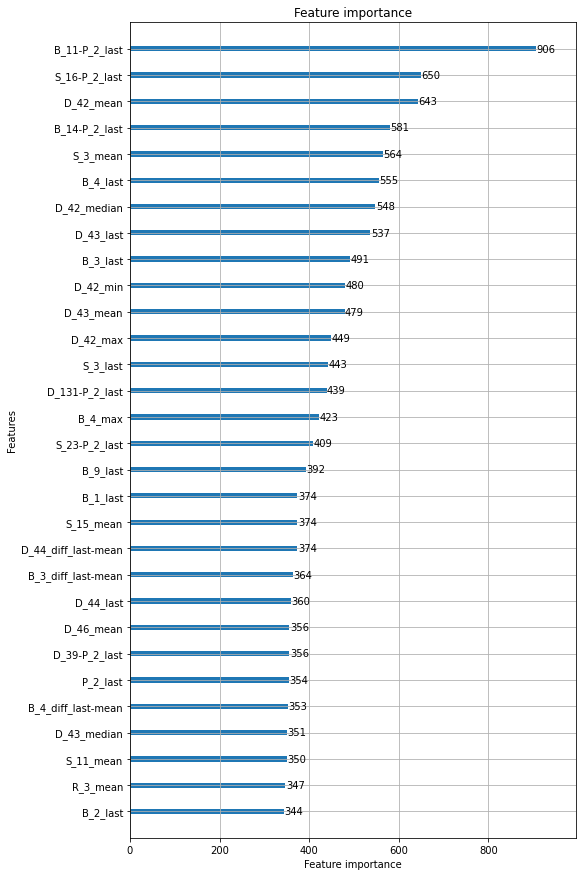

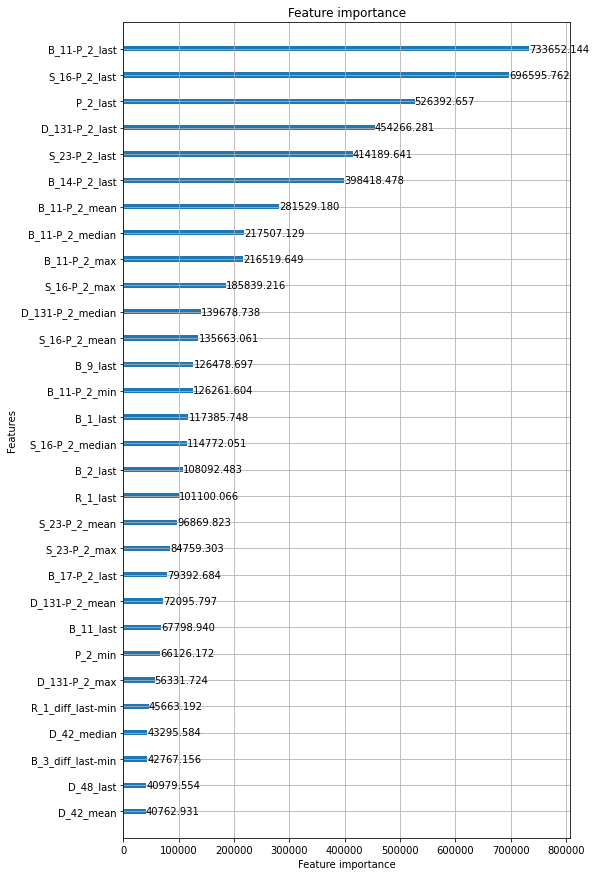

######################################## training model 5/5 ########################################


/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[50]	valid_0's amex_metric: 0.758422	valid_0's recall_at4: 0.613255	valid_0's norm_gini: 0.903589


[100]	valid_0's amex_metric: 0.766727	valid_0's recall_at4: 0.625794	valid_0's norm_gini: 0.90766


[150]	valid_0's amex_metric: 0.770449	valid_0's recall_at4: 0.630928	valid_0's norm_gini: 0.90997


[200]	valid_0's amex_metric: 0.772039	valid_0's recall_at4: 0.632821	valid_0's norm_gini: 0.911257


[250]	valid_0's amex_metric: 0.775061	valid_0's recall_at4: 0.636987	valid_0's norm_gini: 0.913136


[300]	valid_0's amex_metric: 0.777112	valid_0's recall_at4: 0.63968	valid_0's norm_gini: 0.914544


[350]	valid_0's amex_metric: 0.778813	valid_0's recall_at4: 0.642163	valid_0's norm_gini: 0.915464


[400]	valid_0's amex_metric: 0.779722	valid_0's recall_at4: 0.643341	valid_0's norm_gini: 0.916103


[450]	valid_0's amex_metric: 0.781952	valid_0's recall_at4: 0.646792	valid_0's norm_gini: 0.917112


[500]	valid_0's amex_metric: 0.784155	valid_0's recall_at4: 0.650116	valid_0's norm_gini: 0.918195


[550]	valid_0's amex_metric: 0.785772	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.919156


[600]	valid_0's amex_metric: 0.78691	valid_0's recall_at4: 0.653903	valid_0's norm_gini: 0.919917


[650]	valid_0's amex_metric: 0.788186	valid_0's recall_at4: 0.656091	valid_0's norm_gini: 0.920282


[700]	valid_0's amex_metric: 0.788677	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.920757


[750]	valid_0's amex_metric: 0.789734	valid_0's recall_at4: 0.658363	valid_0's norm_gini: 0.921106


[800]	valid_0's amex_metric: 0.789667	valid_0's recall_at4: 0.657942	valid_0's norm_gini: 0.921392


[850]	valid_0's amex_metric: 0.790748	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.92166


[900]	valid_0's amex_metric: 0.790402	valid_0's recall_at4: 0.658868	valid_0's norm_gini: 0.921936


[950]	valid_0's amex_metric: 0.790963	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.922216


[1000]	valid_0's amex_metric: 0.791431	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.922478


[1050]	valid_0's amex_metric: 0.791045	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.922801


[1100]	valid_0's amex_metric: 0.791629	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.923002


[1150]	valid_0's amex_metric: 0.791815	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.923163


[1200]	valid_0's amex_metric: 0.791992	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.923265


[1250]	valid_0's amex_metric: 0.793226	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.923419


[1300]	valid_0's amex_metric: 0.793669	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.923421


[1350]	valid_0's amex_metric: 0.79372	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.923522


[1400]	valid_0's amex_metric: 0.794101	valid_0's recall_at4: 0.664507	valid_0's norm_gini: 0.923696


[1450]	valid_0's amex_metric: 0.794486	valid_0's recall_at4: 0.66518	valid_0's norm_gini: 0.923791


[1500]	valid_0's amex_metric: 0.794205	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.923861


[1550]	valid_0's amex_metric: 0.794465	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.924003


[1600]	valid_0's amex_metric: 0.794103	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.924121


[1650]	valid_0's amex_metric: 0.794076	valid_0's recall_at4: 0.66396	valid_0's norm_gini: 0.924193


[1700]	valid_0's amex_metric: 0.794411	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.924189


[1750]	valid_0's amex_metric: 0.794577	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.924269


[1800]	valid_0's amex_metric: 0.7945	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.924325


[1850]	valid_0's amex_metric: 0.794503	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.924415


[1900]	valid_0's amex_metric: 0.795079	valid_0's recall_at4: 0.665685	valid_0's norm_gini: 0.924473


[1950]	valid_0's amex_metric: 0.795201	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.924506


[2000]	valid_0's amex_metric: 0.796063	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924589


[2050]	valid_0's amex_metric: 0.795472	valid_0's recall_at4: 0.666274	valid_0's norm_gini: 0.924669


[2100]	valid_0's amex_metric: 0.795193	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924742


[2150]	valid_0's amex_metric: 0.796283	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.924819


[2200]	valid_0's amex_metric: 0.795782	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.92487


[2250]	valid_0's amex_metric: 0.796209	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924881


[2300]	valid_0's amex_metric: 0.796203	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.92487


[2350]	valid_0's amex_metric: 0.79661	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.924842


[2400]	valid_0's amex_metric: 0.796756	valid_0's recall_at4: 0.668672	valid_0's norm_gini: 0.924839


[2450]	valid_0's amex_metric: 0.796006	valid_0's recall_at4: 0.667158	valid_0's norm_gini: 0.924855


[2500]	valid_0's amex_metric: 0.796002	valid_0's recall_at4: 0.667158	valid_0's norm_gini: 0.924846


[2550]	valid_0's amex_metric: 0.795955	valid_0's recall_at4: 0.667031	valid_0's norm_gini: 0.924878


[2600]	valid_0's amex_metric: 0.796593	valid_0's recall_at4: 0.668252	valid_0's norm_gini: 0.924935


[2650]	valid_0's amex_metric: 0.796434	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.924953


[2700]	valid_0's amex_metric: 0.796652	valid_0's recall_at4: 0.668336	valid_0's norm_gini: 0.924969


[2750]	valid_0's amex_metric: 0.796351	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.924997


[2800]	valid_0's amex_metric: 0.796065	valid_0's recall_at4: 0.667116	valid_0's norm_gini: 0.925015


[2850]	valid_0's amex_metric: 0.796891	valid_0's recall_at4: 0.668757	valid_0's norm_gini: 0.925025


[2900]	valid_0's amex_metric: 0.796893	valid_0's recall_at4: 0.668757	valid_0's norm_gini: 0.92503


[2950]	valid_0's amex_metric: 0.796779	valid_0's recall_at4: 0.668546	valid_0's norm_gini: 0.925012


[3000]	valid_0's amex_metric: 0.796903	valid_0's recall_at4: 0.668757	valid_0's norm_gini: 0.925049


[3050]	valid_0's amex_metric: 0.796797	valid_0's recall_at4: 0.668546	valid_0's norm_gini: 0.925047


[3100]	valid_0's amex_metric: 0.796737	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.925011


[3150]	valid_0's amex_metric: 0.795823	valid_0's recall_at4: 0.666611	valid_0's norm_gini: 0.925035


[3200]	valid_0's amex_metric: 0.795962	valid_0's recall_at4: 0.666863	valid_0's norm_gini: 0.925061


[3250]	valid_0's amex_metric: 0.796338	valid_0's recall_at4: 0.667578	valid_0's norm_gini: 0.925098


[3300]	valid_0's amex_metric: 0.796751	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.925125


[3350]	valid_0's amex_metric: 0.796413	valid_0's recall_at4: 0.667663	valid_0's norm_gini: 0.925164


[3400]	valid_0's amex_metric: 0.796345	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.925153


[3450]	valid_0's amex_metric: 0.79613	valid_0's recall_at4: 0.667073	valid_0's norm_gini: 0.925187


[3500]	valid_0's amex_metric: 0.796278	valid_0's recall_at4: 0.667368	valid_0's norm_gini: 0.925188


[3550]	valid_0's amex_metric: 0.79644	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.925175


[3600]	valid_0's amex_metric: 0.796447	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.92519


[3650]	valid_0's amex_metric: 0.796414	valid_0's recall_at4: 0.667663	valid_0's norm_gini: 0.925166


[3700]	valid_0's amex_metric: 0.796899	valid_0's recall_at4: 0.66863	valid_0's norm_gini: 0.925167


[3750]	valid_0's amex_metric: 0.797038	valid_0's recall_at4: 0.668883	valid_0's norm_gini: 0.925194


[3800]	valid_0's amex_metric: 0.797087	valid_0's recall_at4: 0.668967	valid_0's norm_gini: 0.925207


[3850]	valid_0's amex_metric: 0.796882	valid_0's recall_at4: 0.668546	valid_0's norm_gini: 0.925218


[3900]	valid_0's amex_metric: 0.796202	valid_0's recall_at4: 0.667242	valid_0's norm_gini: 0.925162


[3950]	valid_0's amex_metric: 0.79615	valid_0's recall_at4: 0.667158	valid_0's norm_gini: 0.925142


[4000]	valid_0's amex_metric: 0.796389	valid_0's recall_at4: 0.66762	valid_0's norm_gini: 0.925159


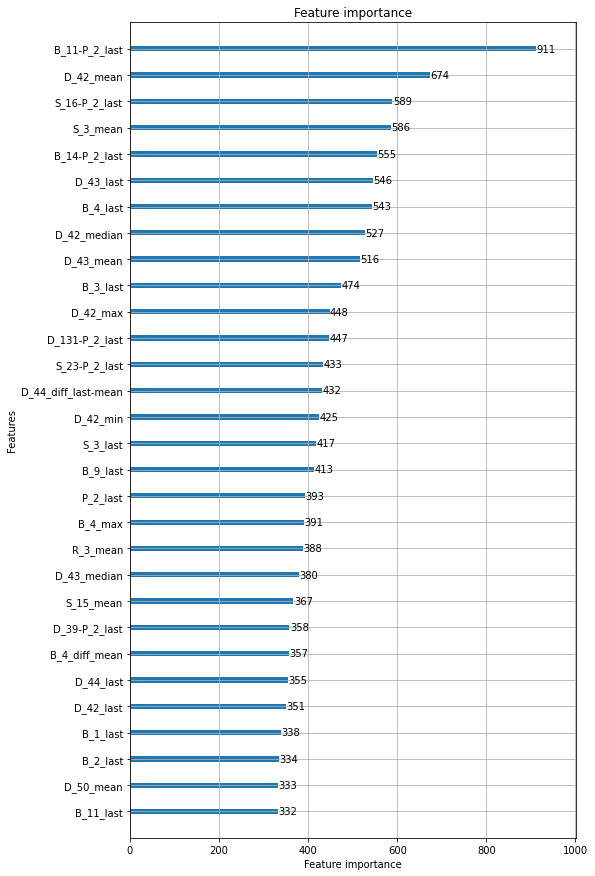

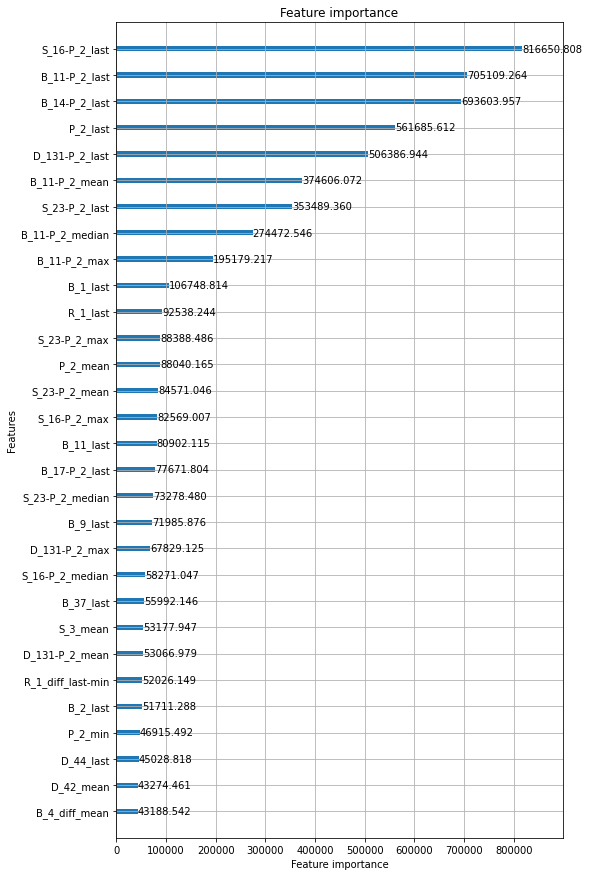

Training time: 98.68716483910879 min.
OOF recall_at4: 0.6705490288484196
OOF normalized_gini: 0.9259753572201742
OOF competition metric: 0.7982621930342969


CPU times: user 3d 15h 34min 27s, sys: 2min 6s, total: 3d 15h 36min 33s
Wall time: 4h 56min 37s


In [11]:
%%time 

all_scalers = list()
all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    scalers,models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_scalers.append(scalers)
    all_models.append(models)
    all_oof_dfs.append(oof)
        
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"model-cv{repetition}-fold{fold}.txt")
    for fold,_scaler in enumerate(scalers):
        joblib.dump(_scaler, ART_PATH/f"scaler-cv{repetition}-fold{fold}.pkl")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.670541,0.925810,0.798175
1,0.671811,0.925937,0.798874
2,0.670549,0.925975,0.798262



mean:


recall_at4    0.670967
gini          0.925907
metric        0.798437
dtype: float64


std:


recall_at4    0.000731
gini          0.000087
metric        0.000381
dtype: float64

In [13]:
del train, all_oof_dfs
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(
        dataframe:pd.DataFrame, 
        input_feats:list,
        numeric_feats:list,
        scalers:list,
        models:list,
    ) -> np.array:
    preds = list()
    for scaler,model in zip(scalers,models):
        _dataframe = dataframe.copy()
        _dataframe[numeric_feats] = scaler.transform(_dataframe[numeric_feats])
        preds.append( model.predict(_dataframe[input_feats]) )
    return np.mean(preds, axis=0)     

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    scalers = all_scalers[repetition]
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, numeric_feats, scalers, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 3h 58min 30s, sys: 1min 35s, total: 4h 6s
Wall time: 17min 30s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.75 s, sys: 81 ms, total: 3.83 s
Wall time: 3.83 s


***